### **Présentation du projet python: Nicolas Hanoun et Lola Josseran**

> Airbnb est une plateforme créée en 2008 où des particuliers peuvent mettre leur logement ou une partie de leur logement en location pour une durée finie. La plateforme permet a un loueur de rechercher les logements disponibles et de réserver celui qui répond à ses attentes. Depuis 2008, la plateforme a eu un immense succès et est utlisé dans 191 pays et comporte plus d'un million d'annonces. Nous avons décidé de centrer notre projet autour de la prédiction des prix de cette plateforme. Paris étant la ville la plus peuplée de France et l'une des villes les plus touristiques au monde, il nous a semblé intéressant de travailler seulement sur les airbnb parisiens.

>Nous sommes ainsi arriver à notre problématique qui est : **Comment fixer le prix de son Airbnb parisien?**

> Notre base de données provient du site open data. Elle comporte environ 55000 airbnb parisiens différents ainsi que 89 colonnes mélangeant variables catégorielles et variables numériques dont le prix par nuit du logement fixé en mai 2017.


## **I) La base de données: premières analyses descriptives**

### *1-Importation des modules et de la base de données*

In [122]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn import datasets
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import requests
import zipfile

In [123]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from string import ascii_letters
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import xgboost as xgb
from xgboost import XGBRegressor

In [124]:
!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade contextily

Requirement already up-to-date: geopandas in /usr/local/lib/python3.6/dist-packages (0.8.1)
Requirement already up-to-date: pyshp in /usr/local/lib/python3.6/dist-packages (2.1.2)
Requirement already up-to-date: shapely in /usr/local/lib/python3.6/dist-packages (1.7.1)
Requirement already up-to-date: descartes in /usr/local/lib/python3.6/dist-packages (1.1.0)
Requirement already up-to-date: contextily in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [125]:
import geopandas as gpd
import contextily as ctx
import folium
import unicodedata

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
data=pd.read_csv("/content/drive/MyDrive/ProjetPython/airbnb-listings.csv",sep=';')
data

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (40,82) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ID  ...                                           Features
0      13323675  ...  Host Has Profile Pic,Is Location Exact,Instant...
1      16364745  ...  Host Has Profile Pic,Host Identity Verified,Is...
2       7197643  ...             Host Has Profile Pic,Is Location Exact
3       8376993  ...  Host Is Superhost,Host Has Profile Pic,Host Id...
4       2604283  ...  Host Has Profile Pic,Host Identity Verified,Is...
...         ...  ...                                                ...
54508    666408  ...  Host Has Profile Pic,Host Identity Verified,Is...
54509  12213089  ...  Host Has Profile Pic,Host Identity Verified,Is...
54510    924904  ...  Host Is Superhost,Host Has Profile Pic,Host Id...
54511   6818759  ...  Host Has Profile Pic,Host Identity Verified,Is...
54512   2556386  ...             Host Has Profile Pic,Is Location Exact

[54513 rows x 89 columns]

### *2- Statistiques descriptives et visualisation de la base*

In [128]:
df=data.drop(["ID", "Features", "Listing Url", "Has Availability", "Calendar Updated", "Scrape ID", "Market", "Country Code", "Country", "Last Scraped", "Experiences Offered", "Interaction", "Thumbnail Url", "Medium Url", "Picture Url", "XL Picture Url", "Host ID", "Host URL", "Host Name", "Host Since", "Host Location", "Host About", "Host Response Time", "Host Acceptance Rate", "Host Response Rate", "Host Thumbnail Url", "Host Picture Url", "Host Neighbourhood", "Host Listings Count", "Host Total Listings Count", "Host Verifications", "Neighbourhood Group Cleansed", "City", "State", "Weekly Price", "Monthly Price", "Security Deposit", "Cleaning Fee", "License", "Jurisdiction Names", "Cancellation Policy", "Calculated host listings count"],axis=1)
df

Name  ...                  Geolocation
0               Studio au coeur du Marais  ...  48.8580288026,2.35608793562
1      Cozy appart in the centre of Paris  ...  48.8550970759,2.35811648834
2      Bastille apartment, view of Paris!  ...  48.8498465526,2.36570613737
3       STUNNING 2BR HEART MARAIS 2 BATHS  ...  48.8565368227,2.36060952878
4           LE MARAIS Charming apartment!  ...  48.8549690001,2.36245276321
...                                   ...  ...                          ...
54508   ILE SAINT-LOUIS + AIRPORT PICK-UP  ...  48.8512553243,2.35647388846
54509    Marais Attic 1 bedroom apartment  ...  48.8587179481,2.35261913416
54510     Sunny and quiet apt in Bastille  ...  48.8497182764,2.36504691864
54511     Le Marais Historical Appartment  ...  48.8580619895,2.35639324453
54512           Studio étudiant LE MARAIS  ...  48.8588930894,2.35638871886

[54513 rows x 47 columns]

On commence par supprimer les features du DataFrame qui sont inutiles pour notre étude, on passe de 89 à **47 features**.

On a différents **type de features** que l'on peut catégoriser en 5:

- *Price*: le prix par nuit de mai 2017

- *Variables de type hôtellerie:* Property Type, Room Type, Accommodates, Bathrooms, Bedrooms, Beds, Bed Type,  Minimum Night, Maximum Night, Guests Included, Extra people, Square Feet

- *Variables géographiques:* Street, Zipcode, Neighbourhood, Neighborhood Overview,NNeighbourhood Clenased, Smart Location, Latitude, Longitude, Geolocation

- *Variables de description:* Amenities, Name, Summary, Space, Description, Transit, Access, House Rules, Features

- *Variables de notes ou critiques:* Reviews per Month, Review Scores Value, Review Scores Location, Review Scores Communication, Review Scores Cleanliness, Review Scores Checkin, Review Scores Rating, Review Scores Accuracy, Number of Reviews, Last review, First review



In [129]:
data_2 = df.select_dtypes(include = ['float64', 'int64'])
data_2.head()

Latitude  Longitude  ...  Review Scores Value  Reviews per Month
0  48.858029   2.356088  ...                 10.0               0.20
1  48.855097   2.358116  ...                 10.0               0.29
2  48.849847   2.365706  ...                  NaN                NaN
3  48.856537   2.360610  ...                 10.0               1.34
4  48.854969   2.362453  ...                  9.0               5.78

[5 rows x 25 columns]

In [130]:
df["Price"].describe()

count    54459.000000
mean        94.787418
std         73.357710
min          0.000000
25%         55.000000
50%         75.000000
75%        107.000000
max        999.000000
Name: Price, dtype: float64

In [131]:
df=df[df["Price"]!=0]
df=df.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogramme et densité des prix des airbnb parisiens')

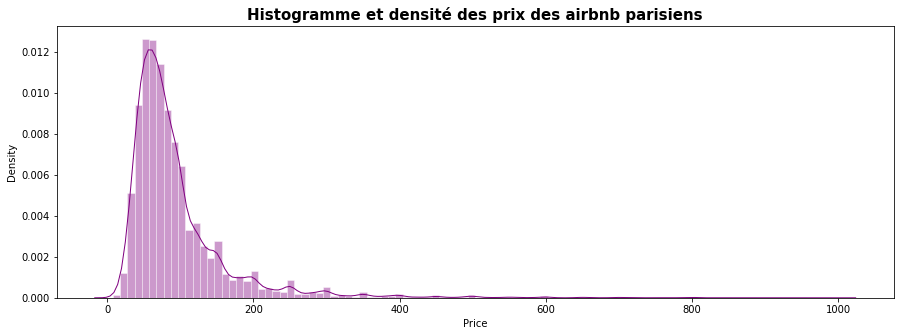

In [132]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.distplot(df["Price"], hist=True, kde=True, bins=int(100), color = 'purple', hist_kws={'edgecolor':'white'},kde_kws={'linewidth': 1})
plt.title("Histogramme et densité des prix des airbnb parisiens" ,size=15, weight='bold')

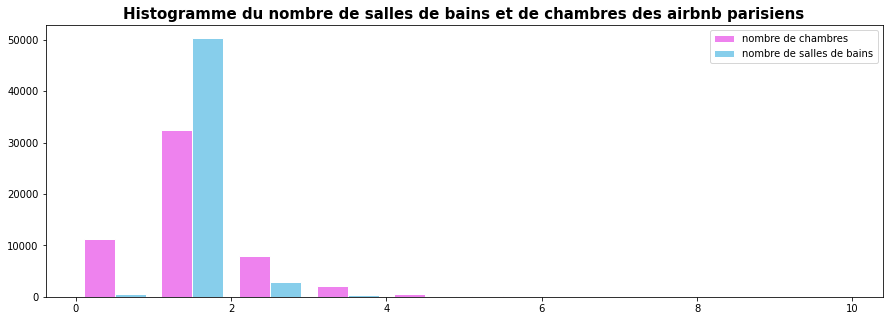

In [133]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.hist([df["Bedrooms"], df["Bathrooms"]], color = ['violet', 'skyblue'], label=['nombre de chambres', 'nombre de salles de bains'], edgecolor = 'white')
plt.title("Histogramme du nombre de salles de bains et de chambres des airbnb parisiens",size=15, weight='bold')
plt.legend()

On observe que le prix par nuit moyen des airbnb à Paris est de **94,78 euros** et que la grande majorité des prix par nuit se situent entre 0 et 200 euros. On observe également qu'une majorité des logements proposés ne comportent qu'une salle de bains et qu'une chambre.

Matrice de corrélation de toutes les variables numériques de la base df


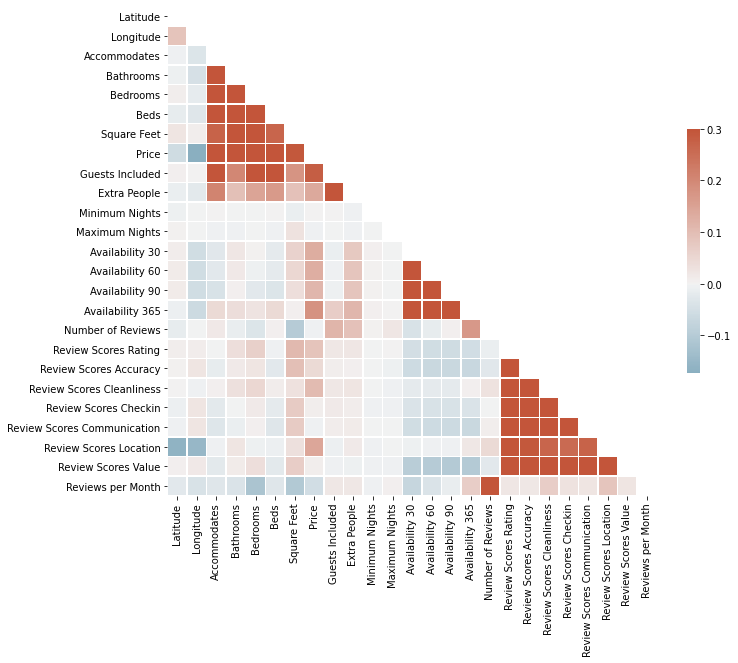

In [134]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
print("Matrice de corrélation de toutes les variables numériques de la base df")

In [135]:
var_corr = df.corr()['Price']
var = var_corr[abs(var_corr) > 0.2].sort_values(ascending=False)
print("Voici les {} variables les plus fortement corrélées avec le prix par nuit:\n{}".format(len(var), var))

Voici les 7 variables les plus fortement corrélées avec le prix par nuit:
Price              1.000000
Accommodates       0.578680
Bedrooms           0.548549
Beds               0.506751
Bathrooms          0.465715
Square Feet        0.293823
Guests Included    0.281018
Name: Price, dtype: float64


In [136]:
important_listings = df[['Accommodates','Bathrooms','Bedrooms','Beds', 'Square Feet', 'Guests Included']]
important_listings.describe()

Accommodates     Bathrooms  ...   Square Feet  Guests Included
count  54512.000000  54328.000000  ...   2103.000000     54512.000000
mean       3.034543      1.093230  ...    389.671422         1.389125
std        1.477898      0.379975  ...    601.426309         0.880756
min        1.000000      0.000000  ...      0.000000         1.000000
25%        2.000000      1.000000  ...      0.000000         1.000000
50%        2.000000      1.000000  ...    323.000000         1.000000
75%        4.000000      1.000000  ...    538.000000         1.000000
max       16.000000      8.000000  ...  15059.000000        16.000000

[8 rows x 6 columns]

In [137]:
print('valeurs manquantes dans le dataframe: \n')
print(df.isnull().sum())
print('\n')
print('Pourcentage de valeurs manquantes pour la variable mètres carrés: ')
print(round(df['Square Feet'].isnull().sum()/len(df)*100, 2),"%")

valeurs manquantes dans le dataframe: 

Name                               3
Summary                         2145
Space                          16537
Description                        7
Neighborhood Overview          21843
Notes                          37032
Transit                        19504
Access                         26683
House Rules                    25246
Street                             0
Neighbourhood                   7523
Neighbourhood Cleansed             0
Zipcode                          720
Smart Location                     0
Latitude                           0
Longitude                          0
Property Type                      0
Room Type                          0
Accommodates                       0
Bathrooms                        184
Bedrooms                         134
Beds                              75
Bed Type                           0
Amenities                        406
Square Feet                    52409
Price                             5

En regardant la matrice de corrélation, on réalise que les variables impactants le plus le prix par nuit sont le nombre de personnes que peut accueillir le logement, le nombre de chambres, le nombre de lits, le nombre de salles de bains, le nombre de mètre carrés ainsi que le nombre d'invités qu'on peut y amener. On remarque cependant que la variable mètre carrées peut être améliorer puisqu'il y a 96,14% de valeurs manquantes. On s'intéressera à cette variable en particulier dans la partie 2.

In [138]:
df[['Neighbourhood', 'Price']].groupby(['Neighbourhood']).mean().sort_values(by='Price',ascending=False).head(n=10)

Price
Neighbourhood                             
Cannes                          180.000000
Madeleine - Vendôme             167.272300
Louvre - Tuileries              164.079365
Champs-Elysées                  159.285714
Tour Eiffel - Champs de Mars    157.578947
Notre Dame - Ile de La Cité     152.948276
Monceau                         149.934718
VI Arrondissement               148.333333
Saint-Germain-des-Prés - Odéon  148.236806
Saint-Paul - Ile Saint-Louis    144.083333

In [139]:
df_cannes=df[df["Neighbourhood"]=="Cannes"]
df_cannes

Name  ...                  Geolocation
26339  Perfect flat for friends and family  ...  48.8817958585,2.37313376631

[1 rows x 47 columns]

In [140]:
top_10_neigh = pd.DataFrame(df['Neighbourhood Cleansed'].value_counts().head(5))
top_10_neigh.columns=['Listings']
top_10_neigh['Neighbourhood Cleansed'] = top_10_neigh.index
top_10_neigh.reset_index(drop=True, inplace=True)
top_10_neigh

Listings Neighbourhood Cleansed
0      6315      Buttes-Montmartre
1      5381             Popincourt
2      4000              Vaugirard
3      3749               Entrepôt
4      3547    Batignolles-Monceau

In [141]:
df_neigh=df[(df["Neighbourhood Cleansed"]== "Buttes-Montmartre") ^(df["Neighbourhood Cleansed"]== "Popincourt")^ (df["Neighbourhood Cleansed"]== "Vaugirard") ^ (df["Neighbourhood Cleansed"]== "Entrepôt") ^ (df["Neighbourhood Cleansed"]== "Batignolles-Monceau")]

Text(0, 0.5, 'Price')

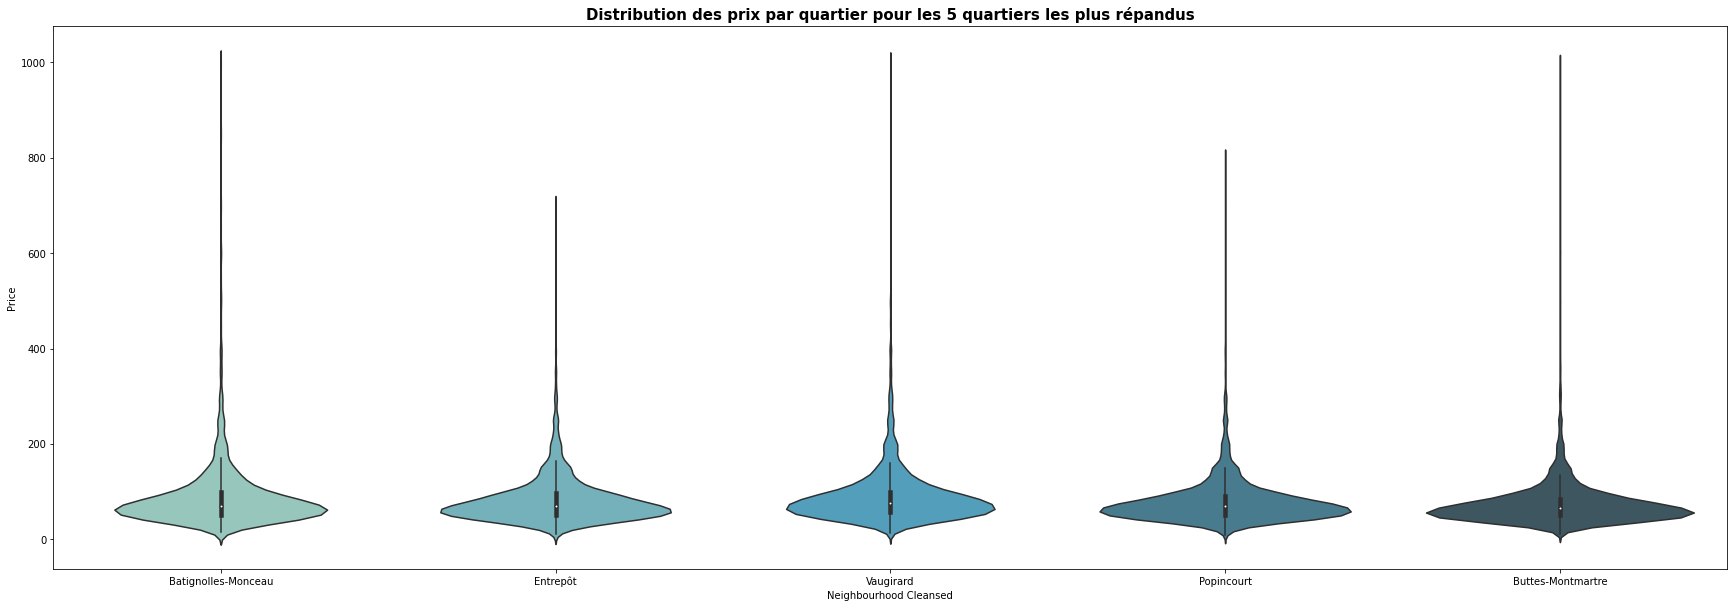

In [142]:
plt.figure(figsize=(30,10))
sns.violinplot(data=df_neigh, x='Neighbourhood Cleansed', y='Price', palette='GnBu_d')
plt.title('Distribution des prix par quartier pour les 5 quartiers les plus répandus' ,size=15, weight='bold')
plt.xlabel('Neighbourhood Cleansed')
plt.ylabel("Price")

In [143]:
df[['Neighbourhood Cleansed', 'Price']].groupby(['Neighbourhood Cleansed']).mean().sort_values(by='Price',ascending=True).head(n=5)

Price
Neighbourhood Cleansed           
Ménilmontant            65.175444
Buttes-Chaumont         66.420285
Gobelins                72.221764
Buttes-Montmartre       74.813243
Reuilly                 77.828770

In [144]:
df_comp=df[["Neighbourhood", "Neighbourhood Cleansed"]]
df_comp.describe()

Neighbourhood Neighbourhood Cleansed
count          46989                  54512
unique            63                     20
top       Montmartre      Buttes-Montmartre
freq            3151                   6315

In [145]:
df.groupby("Smart Location")["Smart Location"].count()

Smart Location
Paris , France           21
Paris, France         54490
Paris, Switzerland        1
Name: Smart Location, dtype: int64

In [146]:
df=df.drop(["Neighbourhood", "Street", "Smart Location"], axis=1)

On a deux features sur le quartier dans notre base: Neighbourhood et Neighbourhood Cleansed. En regardant les quartiers les plus chers (d'après la variable Neighbourhood) on tombe sur Cannes qui n'est pas un quartier de Paris. La variable Neighbourhood Cleansed nous donne Buttes-Chaumont comme quartier de ce même logement qui est un vrai quartier de Paris. En regardant plus en détails, on observe que Neighbourhood n'est pas rempli pour toutes les données et qu'elle comporte 63 quartiers différents alors que l'autre feature est remplie pour tous les logements et ne donnent que 20 quartiers. Même si l'on perd en informations, il semble plus judicieux d'utiliser la variable Neighbourhood Cleansed qui donne les bons quartiers. On supprime également la variable Street qui suit Neighbourhood donc qui n'est pas très utile ainsi que la variable Smart Location qui donne simplement Paris pour tous les logements. On verra plus tard comment on va essayer dans la partie 3 d'améliorer les features concernant la géographie et le quartier du logement.

No handles with labels found to put in legend.


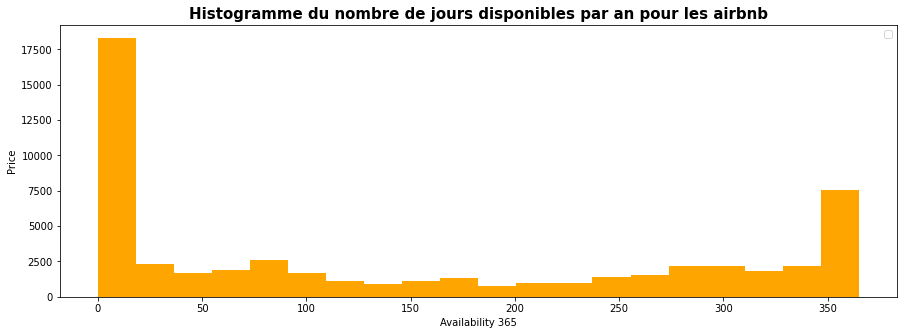

In [147]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.hist(df["Availability 365"],bins=int(20), color='orange')
plt.title("Histogramme du nombre de jours disponibles par an pour les airbnb",size=15, weight='bold')
plt.xlabel("Availability 365")
plt.ylabel("Price")
plt.legend()

On a un tiers des logements qui sont proposés moins de 50 jours par an, ce qui semble bien correpsondre à l'application où les gens peuvent louer leur appartement à d'autres pour une courte durée, par exemple si ils partent en vacances. On observe cependant qu'il y a plus de 10000 logements qui sont proposés plus de 300 jours dans l'année ce qui semble énorme et corresponderait plus à des hôtels qu'à des airbnb. On affinera cette relfexion dans la partie 2 avec la variable Property Type.

In [148]:
df[['Review Scores Value', 'Price']].groupby(['Review Scores Value']).mean().sort_values(by='Price',ascending=False).head(n=10)

Price
Review Scores Value           
4.0                  96.066667
9.0                  93.887495
7.0                  93.607280
10.0                 92.959071
5.0                  92.562500
6.0                  91.498861
8.0                  88.337924
2.0                  84.350877
3.0                  78.400000

In [149]:
df[['Reviews per Month', 'Price']].groupby(['Reviews per Month']).mean().sort_values(by='Price',ascending=False).head(n=10)

Price
Reviews per Month            
8.03               250.000000
7.86               180.000000
5.67               179.500000
11.82              167.000000
6.15               163.000000
8.71               159.000000
5.82               155.000000
6.38               154.500000
8.00               150.000000
5.51               144.333333

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


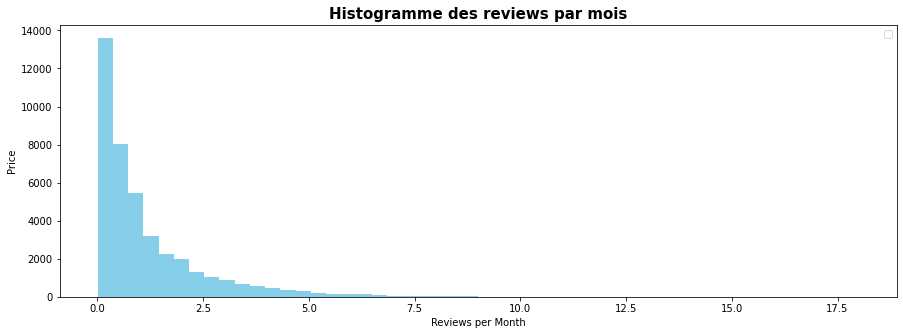

In [150]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.hist(df["Reviews per Month"],bins=int(50), color='skyblue')
plt.title("Histogramme des reviews par mois",size=15, weight='bold')
plt.xlabel("Reviews per Month")
plt.ylabel("Price")
plt.legend()

Text(0.5, 1.0, "Prix en fonction du nombre de notes sur l'appartement")

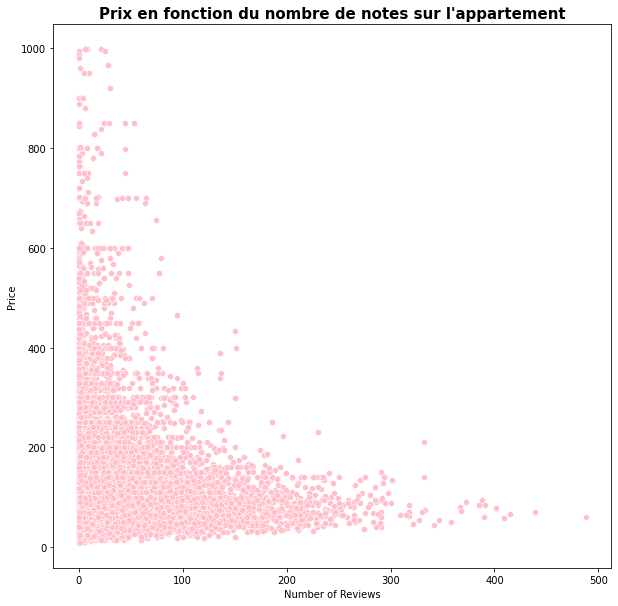

In [151]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="Number of Reviews", y="Price", color='pink', data=df)

plt.xlabel("Number of Reviews")
plt.ylabel("Price")
plt.title("Prix en fonction du nombre de notes sur l'appartement",size=15, weight='bold')

Text(0.5, 1.0, 'Prix en fonction de la note donnée par les anciens loueurs du airbnb et du nombre de personnes que le airbnb peut accueillir')

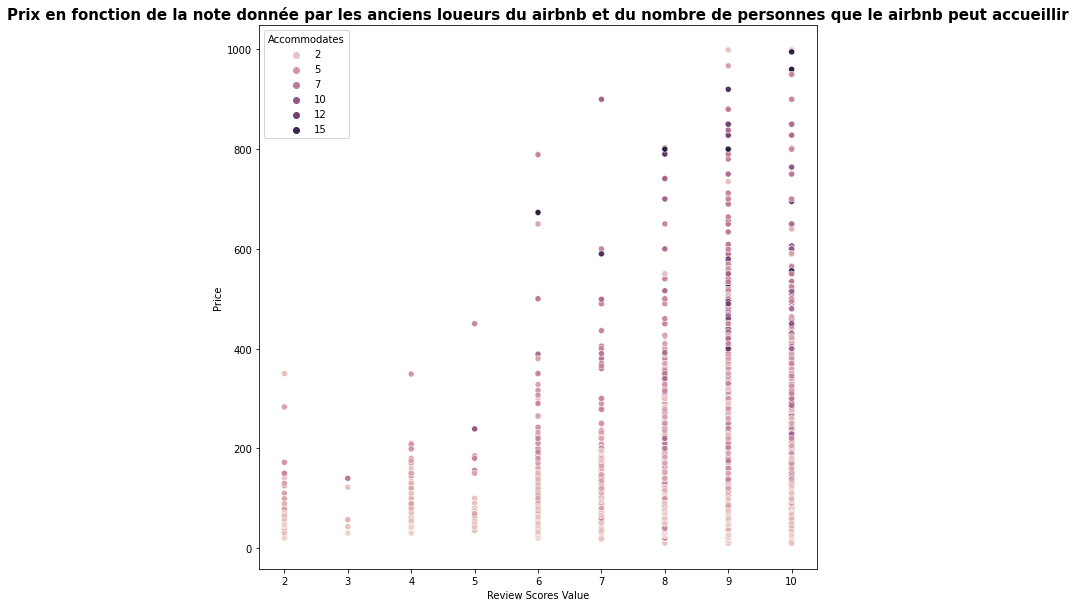

In [152]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="Review Scores Value", y="Price", color='pink', data=df, hue="Accommodates")

plt.xlabel("Review Scores Value")
plt.ylabel("Price")
plt.title("Prix en fonction de la note donnée par les anciens loueurs du airbnb et du nombre de personnes que le airbnb peut accueillir",size=15, weight='bold')

On a choisi d'étudier 4 variables concernant les reviews mises en ligne par les personnes ayant logés dans le airbnb. On ne trouve pas vraiment de corrélation entre Review Scores Value et le Prix moyen correspondant, on a les 2 derniers du classement qui correspondent aux pires notes (2 et 3) mais le premier du classement correpsond à 4. Pour ce qui est des Reviews per Month, on observe que les logements les plus chers ont un niveau assez élevé de Reviews per Month, entre 5,5 et 8,7 alors qu'une grande majorité des logements ont un Reviews per Month inférieur à 5 si on regarde l'histogramme. 

Pour Number of Reviews, on observe clairement une corrélation négative avec le prix. Une interprétation possible est que moins le airbnb est cher, plus il y a de personnes qui vont logés là bas pour quelques jours et plus il va y avoir de reviews concernant cet appartement. On pourrait aussi interpréter du point de vue de la personne mettant en ligne le logement. Plus le prix du logement est cher et plus l'habitant va sélectionner les profils et ne pas faire venir beaucoup de gens chez lui.

Pour finir, on a tracé le prix en fonction de Review Scores Value et du nombre de personnes que peut accueillir le logement. On observe cette fois-ci une corrélation positive entre la note et le prix, plus le prix est élevé plus le logement est de qualité et plus la note du loueur augmente. On observe également que les logements accueillant plus de 10 personnes ont quasiment tous une note supérieur à 5.

# **II) Nettoyage de la base et traitement des variables**

### *1- Création de la variable Arrondissement à partir de la variable Zipcode*

L'objectif ici est de créer la variable arrondissement qui nous servira dans la partie 3 à joindre une autre table à la base de données initiale. On l'a récupère à partir de la variable Zipcode contenant les codes postals  750** ou le ** correspond au numéro de l'arrondissement. 
On observe ensuite que les trois arrondissements les plus chers de Paris sont le 8, le 6 et le 1.

In [153]:
df_3=df[["Zipcode"]]
df_3.describe()

Zipcode
count    53792
unique      77
top      75018
freq      5700

In [154]:
df.groupby("Zipcode")["Zipcode"].count()

Zipcode
75001.0        127
75002.0        123
75003.0        239
75004.0        228
75005.0        218
              ... 
94250            1
Montmartre       1
Paris            2
Paris 75004      1
adf              1
Name: Zipcode, Length: 77, dtype: int64

In [155]:
df["Zipcode"].unique()

array(['75004', '75003', '75017', '75010', '75009', '75002', '75018',
       '75007', nan, '75006', '75008', '75015', '75012', '75011', '75001',
       '75014', '75116', '92130', '75013', '75019', '75020', '75005',
       '75016', '92100', '75000', '75003\n75003', '750016', '075016',
       '93170', '75018e', '75106', '75', '92170', '700014', 'Paris',
       '92300', '76016', '75011\n75011', '7015', '750018', '94160',
       '78008', '78005', 'Paris 75004', '75014\n75014', '75011 PARIS',
       '750109', '75 018', '94250', '93310', '93300', '92200', 'adf',
       'Montmartre', '92240', 75002.0, 75003.0, 75010.0, 75018.0, 75004.0,
       75011.0, 75001.0, 75017.0, 75007.0, 75015.0, 75006.0, 75019.0,
       75020.0, 75009.0, 75008.0, 75116.0, 75013.0, 75014.0, 75012.0,
       75005.0, 75016.0, 93300.0, 92130.0], dtype=object)

In [156]:
df["Arrondissement"]=0

In [157]:
#ULTRA MEGA PAS OPTI : UTILISE CE QUE J'AI FAIT MOI JUSTE EN DESSOUS
for i in range (0,df.shape[0]):
   if (df["Zipcode"][i]=="75001") ^ (df["Zipcode"][i]==75001.0):
     df["Arrondissement"][i]= 1
   elif (df["Zipcode"][i]=="75002") ^ (df["Zipcode"][i]==75002.0):
     df["Arrondissement"][i]= 2
   elif (df["Zipcode"][i]=="75003") ^ (df["Zipcode"][i]==75003.0):
     df["Arrondissement"][i]= 3
   elif (df["Zipcode"][i]=="75004") ^ (df["Zipcode"][i]==75004.0):
     df["Arrondissement"][i]= 4
   elif (df["Zipcode"][i]=="75005") ^ (df["Zipcode"][i]==75005.0):
     df["Arrondissement"][i]= 5
   elif (df["Zipcode"][i]=="75006") ^ (df["Zipcode"][i]==75006.0):
     df["Arrondissement"][i]= 6
   elif (df["Zipcode"][i]=="75007") ^ (df["Zipcode"][i]==75007.0):
     df["Arrondissement"][i]= 7
   elif (df["Zipcode"][i]=="75008") ^ (df["Zipcode"][i]==75008.0):
     df["Arrondissement"][i]= 8
   elif (df["Zipcode"][i]=="75009") ^ (df["Zipcode"][i]==75009.0):
     df["Arrondissement"][i]= 9
   elif (df["Zipcode"][i]=="75010") ^ (df["Zipcode"][i]==75010.0):
     df["Arrondissement"][i]= 10
   elif (df["Zipcode"][i]=="75011") ^ (df["Zipcode"][i]==75011.0):
     df["Arrondissement"][i]= 11
   elif (df["Zipcode"][i]=="75012") ^ (df["Zipcode"][i]==75012.0):
     df["Arrondissement"][i]= 12
   elif (df["Zipcode"][i]=="75013") ^ (df["Zipcode"][i]==75013.0):
     df["Arrondissement"][i]= 13
   elif (df["Zipcode"][i]=="75014") ^ (df["Zipcode"][i]==75014.0):
     df["Arrondissement"][i]= 14
   elif (df["Zipcode"][i]=="75015") ^ (df["Zipcode"][i]==75015.0):
     df["Arrondissement"][i]= 15
   elif (df["Zipcode"][i]=="75016") ^ (df["Zipcode"][i]==75016.0)^ (df["Zipcode"][i]=="75116") ^ (df["Zipcode"][i]==75116.0):
     df["Arrondissement"][i]= 16
   elif (df["Zipcode"][i]=="75017") ^ (df["Zipcode"][i]==75017.0):
     df["Arrondissement"][i]= 17
   elif (df["Zipcode"][i]=="75018") ^ (df["Zipcode"][i]==75018.0):
     df["Arrondissement"][i]= 18
   elif (df["Zipcode"][i]=="75019") ^ (df["Zipcode"][i]==75019.0):
     df["Arrondissement"][i]= 19
   elif (df["Zipcode"][i]=="75020") ^ (df["Zipcode"][i]==75020.0):
     df["Arrondissement"][i]= 20

  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launche

In [158]:
def zipcode_to_arrondissement(x):
  if type(x)==str and x.isdigit()==True:
    if x.startswith('75'):
     y=x[-2:]
     return int(y)
    else: 
      return 0
  else:
    if np.isnan(x)==False:
      if x==75116:
        return int(x-75100)
      else:
        return int(x-75000)
    else :
      return 0

In [159]:
#df["test"]=df["Zipcode"].apply(zipcode_to_arrondissement)

In [160]:
df.groupby("Arrondissement")["Arrondissement"].describe()

count  mean  std   min   25%   50%   75%   max
Arrondissement                                                 
0                782.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0
1               1102.0   1.0  0.0   1.0   1.0   1.0   1.0   1.0
2               1582.0   2.0  0.0   2.0   2.0   2.0   2.0   2.0
3               2198.0   3.0  0.0   3.0   3.0   3.0   3.0   3.0
4               1922.0   4.0  0.0   4.0   4.0   4.0   4.0   4.0
5               1998.0   5.0  0.0   5.0   5.0   5.0   5.0   5.0
6               1833.0   6.0  0.0   6.0   6.0   6.0   6.0   6.0
7               1613.0   7.0  0.0   7.0   7.0   7.0   7.0   7.0
8               1378.0   8.0  0.0   8.0   8.0   8.0   8.0   8.0
9               2375.0   9.0  0.0   9.0   9.0   9.0   9.0   9.0
10              3782.0  10.0  0.0  10.0  10.0  10.0  10.0  10.0
11              5312.0  11.0  0.0  11.0  11.0  11.0  11.0  11.0
12              2134.0  12.0  0.0  12.0  12.0  12.0  12.0  12.0
13              1915.0  13.0  0.0  13.0  13.0  13.0  13.0  13.0
14              2134.0  14.0  0.0  14.0  14.0  14.0  14.0  14.0
15              3951.0  15.0  0.0  15.0  15.0  15.0  15.0  15.0
16              2838.0  16.0  0.0  16.0  16.0  16.0  16.0  16.0
17              3520.0  17.0  0.0  17.0  17.0  17.0  17.0  17.0
18              6260.0  18.0  0.0  18.0  18.0  18.0  18.0  18.0
19              2843.0  19.0  0.0  19.0  19.0  19.0  19.0  19.0
20              3040.0  20.0  0.0  20.0  20.0  20.0  20.0  20.0

In [161]:
df=df[df["Arrondissement"]>0]

In [162]:
df[['Arrondissement', 'Price']].groupby(['Arrondissement']).mean().sort_values(by='Price',ascending=False).head(n=5)

Price
Arrondissement            
8               155.957571
6               141.838798
1               141.251589
7               139.501863
4               131.503904

### *2- Travail sur la variable Amenities*

La variable amenities contient la liste des équipements présents dans le logement comme la Télé, Internet ou la présence d'un détecteur de fumée. L'objectif dans cette partie est de travailler la variable pour la rendre numérique et donc utilisable dans un algorithme. Pour cela, on a créer 3 types de variables:
*   *nombre_equipements*: la longueur de la liste qui nous donnera le nombre d'équipements différents disponibles dans le logement
*   six variables indicatrices: *TV, Internet, Heating, Elevator, Washer, Kitchen*. Elles renvoient un 1 si la cuisine possède la caractéristique et un 0 sinon. On a choisi ici les 6 équipements les plus souvent présents dans les logements.
*   *equipements_rares*: elle renvoie le nombre d'équipements disponibles dans le logement sans compter les 6 équipements les plus présents décrit juste au dessus.

On observe après les avoir créer, que les logements possèdent en moyenne 13,19 équipements et 8,72 rares. Il a environ 95% des logements qui possèdent un chauffage et une cuisine contre seulement 66% qui ont une télé.

In [163]:
df['Amenities'][9]

'TV,Internet,Wireless Internet,Kitchen,Pets allowed,Elevator in building,Heating,Family/kid friendly,Washer,Smoke detector,Essentials'

In [164]:
df=df.dropna(subset=['Amenities'])
df

Name  ... Arrondissement
0               Studio au coeur du Marais  ...              4
1      Cozy appart in the centre of Paris  ...              4
2      Bastille apartment, view of Paris!  ...              4
3       STUNNING 2BR HEART MARAIS 2 BATHS  ...              4
4           LE MARAIS Charming apartment!  ...              4
...                                   ...  ...            ...
54507   ILE SAINT-LOUIS + AIRPORT PICK-UP  ...              4
54508    Marais Attic 1 bedroom apartment  ...              1
54509     Sunny and quiet apt in Bastille  ...              4
54510     Le Marais Historical Appartment  ...              4
54511           Studio étudiant LE MARAIS  ...              3

[53327 rows x 45 columns]

In [165]:
df=df.reset_index(drop=True)

In [166]:
for i in range (0, df.shape[0]):
  a= df["Amenities"][i]
  b=a.split(',')
  df["Amenities"][i]= b
df['Amenities'].head()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0    [Heating, Smoke detector, Essentials, Lock on ...
1    [TV, Wireless Internet, Kitchen, Elevator in b...
2    [TV, Cable TV, Internet, Wireless Internet, Wh...
3    [TV, Cable TV, Internet, Wireless Internet, Ki...
4    [TV, Cable TV, Internet, Wireless Internet, Ki...
Name: Amenities, dtype: object

In [167]:
df['nombre_equipements'] = 0
df["TV"]=0
df["Internet"]=0
df["Elevator"]=0
df["Kitchen"]=0
df["Heating"]=0
df["Washer"]=0

In [168]:
for i in range (0, df.shape[0]):
  a=len(df["Amenities"][i])
  df['nombre_equipements'][i]=a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [169]:
#pas opti du tout non plus comme pour zip code j'ecrirai le code demain 
for i in range (0, df.shape[0]):
  if "TV" in df["Amenities"][i]:
    df["TV"][i]=1
for i in range (0, df.shape[0]):
  if "Internet" in df["Amenities"][i]:
    df["Internet"][i]=1
  elif "Wireless Internet" in df["Amenities"]:
    df["Internet"][i]=1
for i in range (0, df.shape[0]):
  if "Elevator in building" in df["Amenities"][i]:
    df["Elevator"][i]=1
for i in range (0, df.shape[0]):
  if "Kitchen" in df["Amenities"][i]:
    df["Kitchen"][i]=1
for i in range (0, df.shape[0]):
  if "Heating" in df["Amenities"][i]:
    df["Heating"][i]=1
for i in range (0, df.shape[0]):
  if "Washer" in df["Amenities"][i]:
    df["Washer"][i]=1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-package

In [170]:
df["equipements_rares"]=df["nombre_equipements"]-df["TV"]-df["Internet"]-df["Elevator"]-df["Kitchen"]-df["Washer"]-df["Heating"]

In [171]:
df["nombre_equipements"].describe(), df["equipements_rares"].describe()

(count    53327.000000
 mean        13.199880
 std          4.334603
 min          1.000000
 25%         10.000000
 50%         13.000000
 75%         16.000000
 max         50.000000
 Name: nombre_equipements, dtype: float64, count    53327.000000
 mean         8.722467
 std          3.877843
 min          0.000000
 25%          6.000000
 50%          8.000000
 75%         11.000000
 max         44.000000
 Name: equipements_rares, dtype: float64)

In [172]:
columns=["TV", "Internet", "Elevator", "Kitchen", "Heating"]
a=df.groupby("TV")['TV'].sum()/len(df)*100
b=df.groupby("Internet")['Internet'].sum()/len(df)*100
c= df.groupby("Elevator")['Elevator'].sum()/len(df)*100
d=df.groupby("Kitchen")['Kitchen'].sum()/len(df)*100
e=df.groupby("Heating")['Heating'].sum()/len(df)*100
lignes= [a[1], b[1], c[1], d[1], e[1]]
percent=pd.DataFrame(lignes, columns)
print("Pourcentage de logements ayant l'équipement")
percent.columns.name = 'Equipement'
percent

Pourcentage de logements ayant l'équipement


Equipement          0
TV          66.947325
Internet    67.479888
Elevator    43.942093
Kitchen     96.234553
Heating     95.615729

In [173]:
df_test=df[["Price", "nombre_equipements","equipements_rares", "TV", "Internet", "Elevator", "Kitchen", "Washer", "Heating"]]
corr_equipement=df_test.corr()
corr_equipement

Price  nombre_equipements  ...    Washer   Heating
Price               1.000000            0.254164  ...  0.170665  0.042188
nombre_equipements  0.254164            1.000000  ...  0.273072  0.241942
equipements_rares   0.207180            0.965751  ...  0.138309  0.168144
TV                  0.217606            0.313649  ...  0.140951  0.099342
Internet            0.086894            0.279274  ...  0.133085  0.135624
Elevator            0.141886            0.245549  ...  0.078956  0.021658
Kitchen             0.025218            0.135549  ...  0.234484  0.186181
Washer              0.170665            0.273072  ...  1.000000  0.085010
Heating             0.042188            0.241942  ...  0.085010  1.000000

[9 rows x 9 columns]

### *3- Amélioration de la variable square feet grâce à la variable description*

In [174]:
#Fonction qui prend en argument une chaine de caractère venant de la colonne Description, 
'1)la split selon le caractère ' ', '
'2) cherche un marqueur de surface : (ie caractère m2ou m^2) qui se glisse dans le texte'
'3) retourne un entier (int) issue de cette chaine de caractère'
'remarque bon format corrige les erreurs de conversion string to int les plus observées' 

def bon_format(x):
  
  if len(x)>=4 or len(x)<=1 or x=='de'or x[:2]=='sq' or x=="50+" or x=='""':
    y=np.NaN  
  elif x.find("(")==0 or x.find(',')==0 or x.find('a')==0 or x.find('/')==0:
    y=int(x[1:])
  else : 
    x=x.replace(",",".")
    x=x.replace("O","0")
    y=float(x)
  return(y*10)


def transformation(x):
  if type(x)==str :
      L=x.split(" ")
      if "m2" in L :
        i=L.index("m2")
        x=L[i-1]
        y=bon_format(x)
        return(y)
      elif "m^2" in L :
        i=L.index("m^2")
        x=(L[i-1])
        y=bon_format(x)
        return(y)
      else: 
        return(np.NaN)
    

In [175]:
Sq_feet=df.copy()
Sq_feet['Intermediaire']=Sq_feet["Description"]
Sq_feet.head()

Name  ...                                      Intermediaire
0           Studio au coeur du Marais  ...  Mon logement est proche de Le Marais hôtel de ...
1  Cozy appart in the centre of Paris  ...  Mon logement est parfait pour les voyageurs en...
2  Bastille apartment, view of Paris!  ...  45 m2 apartment in the heart of Paris, on a qu...
3   STUNNING 2BR HEART MARAIS 2 BATHS  ...  Enjoy le charme à la française of this elegant...
4       LE MARAIS Charming apartment!  ...  Next to Place de Vosges, this luminous apartme...

[5 rows x 54 columns]

In [176]:
#On transforme = on récupère les valeurs de surfaces indiquées dans les descriptions
Sq_feet['Intermediaire']=Sq_feet['Intermediaire'].apply(transformation)

#On fusionne la colonne avec les valeurs existantes et les nouvelles valeurs (si square feet bien mentionné on ne touche pas à la valeur)
Sq_feet_values=pd.concat([Sq_feet['Intermediaire'],Sq_feet['Square Feet']],axis=1)
Sq_feet_values['Intermediaire'].fillna(0, inplace=True)
Sq_feet_values['Square Feet'].fillna(0, inplace=True)

Sq_feet_values['sum'] = Sq_feet_values.loc[(Sq_feet_values['Intermediaire'] ==0) | (Sq_feet_values['Square Feet'] ==0),['Intermediaire','Square Feet']].sum(axis=1)

Sq_feet_values['sum']=Sq_feet_values['sum'].replace(0, np.nan)
Sq_feet_values=Sq_feet_values.dropna()
Sq_feet_values

Intermediaire  Square Feet    sum
2              450.0          0.0  450.0
13               0.0        269.0  269.0
15               0.0        431.0  431.0
20             200.0          0.0  200.0
22               0.0        269.0  269.0
...              ...          ...    ...
53262          140.0          0.0  140.0
53295            0.0        947.0  947.0
53317          110.0          0.0  110.0
53319          580.0          0.0  580.0
53321          250.0          0.0  250.0

[4502 rows x 3 columns]

In [177]:
#Récupération d'un variable Square Feet
def recup_sq_feet(df):
  df['Square Feet']=Sq_feet_values['sum']


In [178]:
Sq_feet_values['Price']=df['Price']

In [179]:
pd.qcut(df["Square Feet"],10,duplicates='drop')

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
53322    NaN
53323    NaN
53324    NaN
53325    NaN
53326    NaN
Name: Square Feet, Length: 53327, dtype: category
Categories (8, interval[float64]): [(-0.001, 97.0] < (97.0, 237.0] < (237.0, 323.0] < (323.0, 409.0] <
                                    (409.0, 484.0] < (484.0, 603.0] < (603.0, 861.0] <
                                    (861.0, 15059.0]]

In [180]:
pd.qcut(Sq_feet_values["Intermediaire"],10,duplicates='drop')

2         (360.0, 450.0]
13       (-740.001, 0.0]
15       (-740.001, 0.0]
20          (0.0, 220.0]
22       (-740.001, 0.0]
              ...       
53262       (0.0, 220.0]
53295    (-740.001, 0.0]
53317       (0.0, 220.0]
53319     (560.0, 750.0]
53321     (220.0, 300.0]
Name: Intermediaire, Length: 4502, dtype: category
Categories (8, interval[float64]): [(-740.001, 0.0] < (0.0, 220.0] < (220.0, 300.0] < (300.0, 360.0] <
                                    (360.0, 450.0] < (450.0, 560.0] < (560.0, 750.0] <
                                    (750.0, 4000.0]]

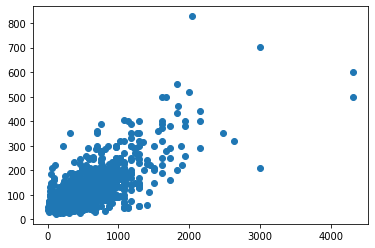

In [181]:
#filtered = df.groupby('Bed Type').filter(lambda x: len(x) >= 1000)
df1=df.copy()
df1=df1[df1['Square Feet']>0]
df1=df1[df1['Square Feet']<5000]
plt.scatter(df1["Square Feet"], df1['Price'])
plt.show()

In [182]:
Sq_feet_values.head()

Intermediaire  Square Feet    sum  Price
2           450.0          0.0  450.0   70.0
13            0.0        269.0  269.0   83.0
15            0.0        431.0  431.0  149.0
20          200.0          0.0  200.0   70.0
22            0.0        269.0  269.0   69.0

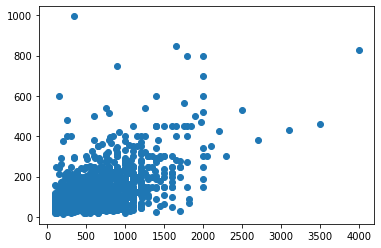

In [183]:
df2=Sq_feet_values.copy()
df2=df2[df2['Intermediaire']>0]
df2=df2[df2['Intermediaire']<5000]
plt.scatter(df2["Intermediaire"], df2['Price'])
plt.show()

### *4- Encodage des variables Property Type, Room Type et Bed Type*

In [184]:
df['Property Type'].nunique(), df['Room Type'].nunique(), df['Bed Type'].nunique()


(24, 3, 5)

In [185]:
prix_property = df.groupby('Property Type').agg({'Price': ['mean']}).reset_index().set_index('Property Type')
prix_property

Price
                          mean
Property Type                 
Apartment            93.600734
Bed & Breakfast      97.310345
Boat                201.000000
Boutique hotel      135.710526
Bungalow             72.000000
Cabin                98.714286
Camper/RV           379.000000
Cave                 38.000000
Chalet              720.000000
Condominium          86.721774
Dorm                 25.524590
Earth House          77.500000
Guesthouse           88.457143
Hostel               44.787879
House               149.698324
Igloo               289.500000
Loft                142.175170
Other               101.006410
Serviced apartment  118.296296
Timeshare           116.333333
Tipi                 80.000000
Townhouse           153.500000
Treehouse            34.000000
Villa               297.500000

In [186]:
df.groupby("Room Type")["Room Type"].count()

Room Type
Entire home/apt    45965
Private room        6846
Shared room          516
Name: Room Type, dtype: int64

Text(0.5, 1.0, 'Prix en fonction du type de chambre')

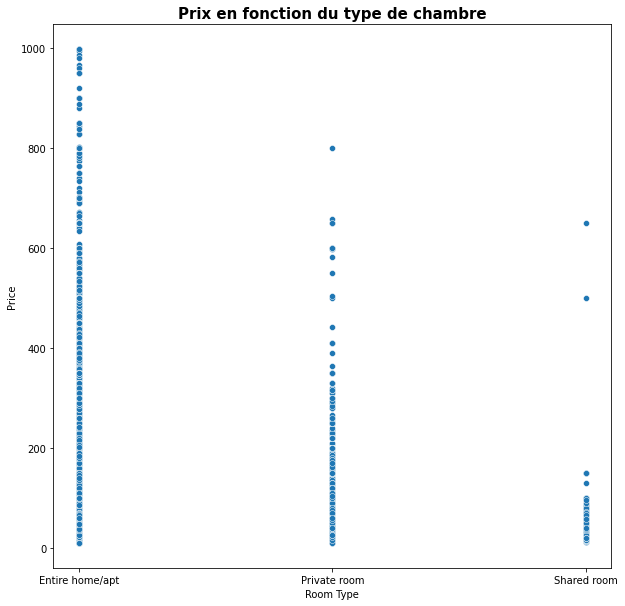

In [187]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="Room Type", y="Price", data=df)

plt.xlabel("Room Type")
plt.ylabel("Price")
plt.title("Prix en fonction du type de chambre",size=15, weight='bold')

In [188]:
df.groupby("Bed Type")["Bed Type"].count()

Bed Type
Airbed              31
Couch              898
Futon              365
Pull-out Sofa     4235
Real Bed         47798
Name: Bed Type, dtype: int64

Text(0.5, 1.0, 'Prix en fonction du type de lit')

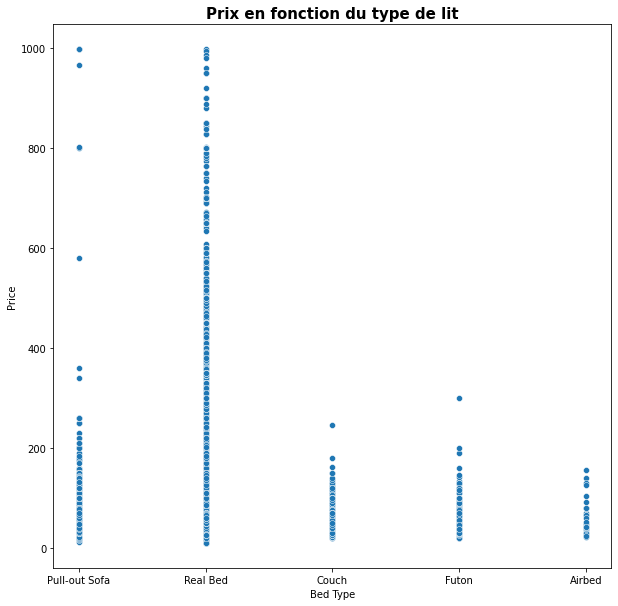

In [189]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="Bed Type", y="Price", data=df)

plt.xlabel("Bed Type")
plt.ylabel("Price")
plt.title("Prix en fonction du type de lit",size=15, weight='bold')

In [190]:
df=df[(df["Property Type"]== "Apartment") ^ (df["Property Type"]== "Loft")^ (df["Property Type"]== "House") ]

In [191]:
df=df.reset_index(drop=True)
df

Name  ... equipements_rares
0               Studio au coeur du Marais  ...                 6
1      Cozy appart in the centre of Paris  ...                 5
2      Bastille apartment, view of Paris!  ...                10
3       STUNNING 2BR HEART MARAIS 2 BATHS  ...                14
4           LE MARAIS Charming apartment!  ...                12
...                                   ...  ...               ...
52091   ILE SAINT-LOUIS + AIRPORT PICK-UP  ...                11
52092    Marais Attic 1 bedroom apartment  ...                 6
52093     Sunny and quiet apt in Bastille  ...                12
52094     Le Marais Historical Appartment  ...                11
52095           Studio étudiant LE MARAIS  ...                 7

[52096 rows x 53 columns]

> *  On observe que comme on l'avait prédit dans la partie 1 il n'y a pas que des logements de particuliers mais aussi des hôtels, des boutiques hôtels... On a 24 types de logements différents mais 52096 sont des appartements, des lofts ou des maisons. On ne gardera que ces trois types pour la suite de l'étude. On observe aussi que le prix moyen d'un appartement est de 93,6 euros ce qui est très proche du prix moyen de tous les logements. Cela s'explique par le fait qu'une très grande majorité des airbnb proposés à Paris sont des appartements. On a 142,2 euros comme prix moyen pour un loft et 149,7 pour une maison.
*   Pour le type de chambre, on a trois types: une chambre partagé, une chambre privée ou un logement entier. Les chambres partagées ne dépassent pas 200 euros par nuit en dehors de quelques exceptions, les chambres privées ne dépassent pas 400 euros par nuit en dehors aussi de quelques exceptions. Les prix les plus élevés sont atteints par les logements entiers qui représentent 85% des logements proposés.
*   Pour le type de lit, on a 5 types mais presque 90% des logements ont un vrai lit et c'est eux qui atteignent les prix les plus hauts. Les autres types ne dépassent pas les 200 euros sauf pour quelques exceptions. On a notamment deux logements avec un canapé-lit qui atteignent le prix maximum. 


> On encode ces trois variables catégorielles avec un get.dummies qui les transforment en indicatrices pour chaque possibilités.






#### *4.1- Tentative en cherchant des poids à attribuer aux différentes catégories de chaque variable*

In [192]:
#peut faire des graphes choisir le poids des vars 
def boxplot_poids(c):
  plt.figure(figsize=(10,10))
  #plot un boxplot avec toutes les datas 52k lignes
  filtered = df.groupby(c+' Type').filter(lambda x: len(x) >= 200)
  filtered.boxplot('Price',by=c+' Type').plot()
  #plot un boxplot une fois les vars sans square feet indiqué 4.5k lignes
  recup_sq_feet(df)
  with_sq=df.dropna()
  filtered2 = with_sq.groupby(c+' Type').filter(lambda x: len(x) >= 50)
  filtered2.boxplot('Price',by=c+" Type").plot()
  plt.plot



<Figure size 720x720 with 0 Axes>

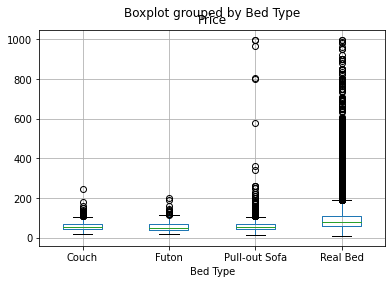

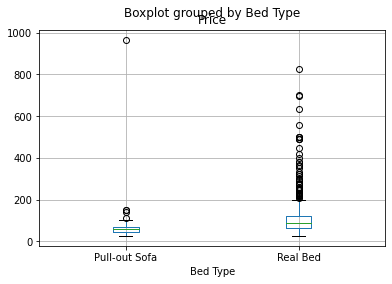

In [193]:
boxplot_poids('Bed')

<Figure size 720x720 with 0 Axes>

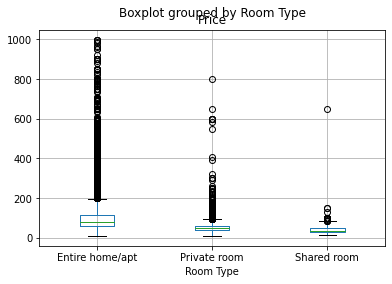

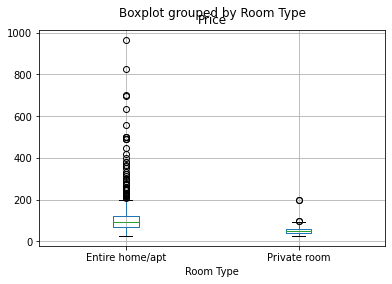

In [194]:
boxplot_poids('Room')

<Figure size 720x720 with 0 Axes>

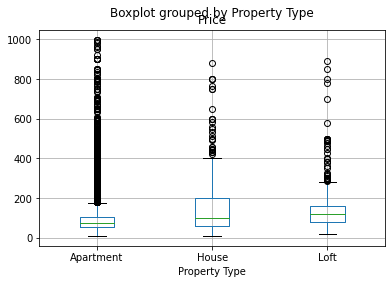

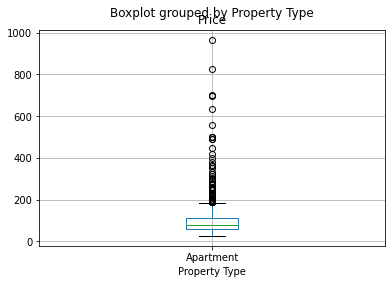

In [195]:
boxplot_poids('Property')

In [196]:
def moyenne_poids(c):
  #plot un boxplot avec toutes les datas 55k lignes
  filtered = df.groupby(c+' Type').filter(lambda x: len(x) >= 200)
  print(filtered.groupby(c+' Type').mean())
  #plot un boxplot une fois les appartements sans square feet indiqué retirés (4.5k lignes)
  recup_sq_feet(df)
  with_sq=df.dropna()
  filtered2 = with_sq.groupby(c+' Type').filter(lambda x: len(x) >= 0)
  print(filtered2.groupby(c+' Type').mean())
  

In [197]:
moyenne_poids('Room')

                  Latitude  Longitude  ...    Washer  equipements_rares
Room Type                              ...                             
Entire home/apt  48.864043   2.344389  ...  0.788001           8.729942
Private room     48.863468   2.349267  ...  0.753114           8.253681
Shared room      48.861868   2.348010  ...  0.653659           8.334146

[3 rows x 34 columns]
                  Latitude  Longitude  ...    Washer  equipements_rares
Room Type                              ...                             
Entire home/apt  48.863616   2.345062  ...  0.833078          10.583461
Private room     48.862621   2.350057  ...  0.666667           9.937500
Shared room      48.851416   2.341214  ...  0.875000          10.125000

[3 rows x 34 columns]


#### *4.2- Encodage opérationnel*

In [198]:
categorical_cols=["Property Type", "Room Type", "Bed Type"]

In [199]:
dummies = pd.get_dummies(df, columns=categorical_cols)
df=dummies
df

Name  ... Bed Type_Real Bed
0               Studio au coeur du Marais  ...                 0
1      Cozy appart in the centre of Paris  ...                 1
2      Bastille apartment, view of Paris!  ...                 1
3       STUNNING 2BR HEART MARAIS 2 BATHS  ...                 1
4           LE MARAIS Charming apartment!  ...                 1
...                                   ...  ...               ...
52091   ILE SAINT-LOUIS + AIRPORT PICK-UP  ...                 1
52092    Marais Attic 1 bedroom apartment  ...                 1
52093     Sunny and quiet apt in Bastille  ...                 1
52094     Le Marais Historical Appartment  ...                 1
52095           Studio étudiant LE MARAIS  ...                 1

[52096 rows x 61 columns]

### *5- Travail sur la variable Description*

La variable Description nous semblait être un facteur intéressant pour prédire le prix d'un airbnb. nous avons donc décider de créer une variable Longueur_desc qui nous permettra d'étudier une possible corrélation entre la longueur et donc la précision d'une description et le prix. On trouve en effet une corrélation positive de 0.105 entre cette variable et le prix ce qui n'est pas négligeable.

In [200]:
df=df.dropna(subset=['Description'])

In [201]:
df= df[df["Description"]!= "..."]
df= df[df["Description"]!= "---"]
df = df[df["Description"]!= "?"]

In [202]:
df=df.reset_index(drop=True)

In [203]:
# opti : utilise apply comme j'ai fait pour le zip code
for i in range (0, df.shape[0]):
  a= df["Description"][i]
  b=a.split(' ')
  df["Description"][i]= b
df['Description'].head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0    [Mon, logement, est, proche, de, Le, Marais, h...
1    [Mon, logement, est, parfait, pour, les, voyag...
2    [45, m2, apartment, in, the, heart, of, Paris,...
3    [Enjoy, le, charme, à, la, française, of, this...
4    [Next, to, Place, de, Vosges,, this, luminous,...
Name: Description, dtype: object

In [204]:
df["Longueur_desc"]=0

In [205]:
for i in range (0, df.shape[0]):
  a= df["Description"][i]
  b=len(a)
  df["Longueur_desc"][i]= b
df['Longueur_desc'].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0     33
1      9
2    148
3    170
4    176
Name: Longueur_desc, dtype: int64

In [206]:
df_de=df[["Price", "Longueur_desc"]]
df_decorr=df_de.corr()
df_decorr

Price  Longueur_desc
Price          1.000000       0.105162
Longueur_desc  0.105162       1.000000

### *6- Création de la variable distance au centre*

Enfin, pour finir le travail d'amélioration et de création de variables à partir de celles présentes dans la base de données initiale, on a décidé de créer une variable calculant la distance au centre-ville de Paris. On a choisi arbitrairement la longitude et la latitude du centre en se basant sur la carte tracée de tous les airbnb de Paris.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


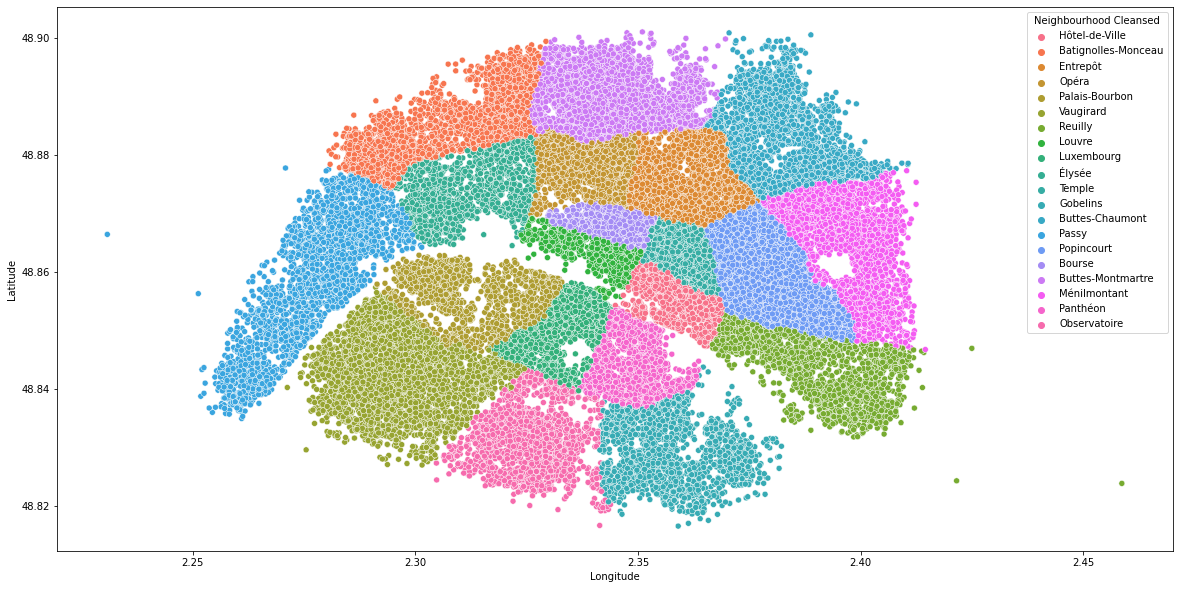

In [207]:
plt.figure(figsize=(20,10))
sns.scatterplot(df["Longitude"],df["Latitude"],hue=df["Neighbourhood Cleansed"])
plt.ioff()

In [208]:
df["lat_centre"]=48.86
df["long_centre"]=2.34
df['distance_centre']=np.sqrt((df["lat_centre"]-df['Latitude'])**2+(df["long_centre"]-df['Longitude'])**2)

In [209]:
df=df.drop(["lat_centre","long_centre"], axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


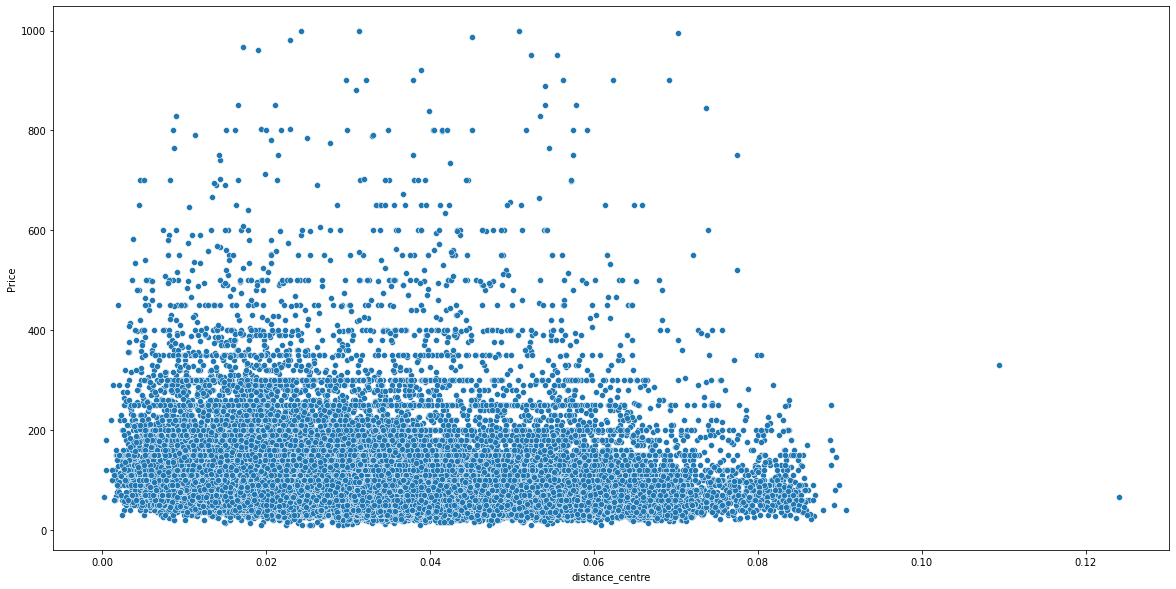

In [210]:
plt.figure(figsize=(20,10))
sns.scatterplot(df["distance_centre"],df["Price"])
plt.ioff()

# **III) Rajout de variables**

In [211]:
df.head()

Name  ... distance_centre
0           Studio au coeur du Marais  ...        0.016208
1  Cozy appart in the centre of Paris  ...        0.018768
2  Bastille apartment, view of Paris!  ...        0.027639
3   STUNNING 2BR HEART MARAIS 2 BATHS  ...        0.020898
4       LE MARAIS Charming apartment!  ...        0.023010

[5 rows x 63 columns]

In [212]:
#Création de la base qui va nous servir pour après
Hotel =["Price", "Bathrooms","Square Feet", "Bedrooms", "Accommodates", "Beds", "Guests Included", "Extra People", "Minimum Nights", "Maximum Nights","Geolocation", "Arrondissement", "Latitude", "Longitude","Availability 365","Number of Reviews","Review Scores Rating", "Review Scores Value","Reviews per Month", "nombre_equipements", "equipements_rares", "TV", "Internet", "Elevator", "Kitchen", "Heating", "Washer", "Property Type_Apartment", "Property Type_House", "Property Type_Loft", "Room Type_Entire home/apt", "Room Type_Private room", "Room Type_Shared room", "Bed Type_Airbed", "Bed Type_Couch", "Bed Type_Futon", "Bed Type_Pull-out Sofa", "Bed Type_Real Bed", "Longueur_desc", "distance_centre"]
Hot=df[Hotel]
Hot.head()


Price  Bathrooms  ...  Longueur_desc  distance_centre
0   40.0        0.5  ...             33         0.016208
1  140.0        1.0  ...              9         0.018768
2   70.0        1.0  ...            148         0.027639
3  276.0        2.0  ...            170         0.020898
4   85.0        1.0  ...            176         0.023010

[5 rows x 40 columns]

##*1- Variables relatives à la division de Pairs par quartier : prix du m2 à l'achat par quartier*

###1.1 matching des bases : 1 les coordonnées géo des quartiers, 2 prix au m2 des quartiers

Import Géopandas vrmt chaud sur notebook classique. La c'est l'import sur colab. Faudrait demander a la prof si on peut partir du principe qu'elle a bien géopandas

In [213]:
def save_file(url, file_name):  
  r = requests.get(url)
  with open(file_name, 'wb') as f:
    f.write(r.content)

    
save_file('https://courses.cs.washington.edu/courses/cse163/19sp/' +
          'files/lectures/05-13/data.zip', 'data.zip')
save_file('https://courses.cs.washington.edu/courses/cse163/19sp/' +
          'files/lectures/05-13/gz_2010_us_040_00_5m.json', 
          'gz_2010_us_040_00_5m.json')
save_file('https://courses.cs.washington.edu/courses/cse163/19sp/' +
          'files/lectures/05-13/stormhistory.csv', 'stormhistory.csv')

with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall()

In [214]:
#données Geojson des quartiers de paris de data.gouv (permet de faire les cartes)
conf_data = gpd.read_file("/content/drive/MyDrive/ProjetPython/quartier_paris.geojson")
df_quartier = pd.DataFrame(conf_data)

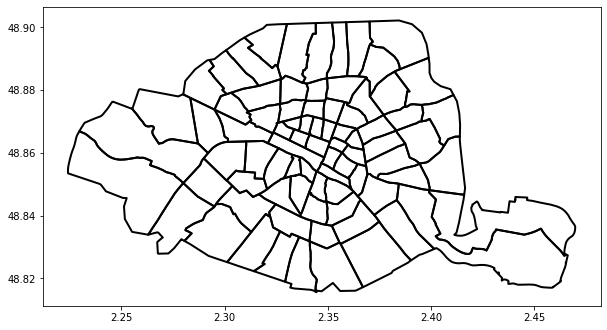

In [215]:
#carte vierge des quartiers de paris issue de data.gouv
ax = conf_data.geometry.boundary.plot(figsize = (10,15), color = None, edgecolor = 'K', linewidth=2)

In [216]:
#chaine de caractère provenant d'un tableau 

c="""Charonne (20e)	8 317 €	8,50%	16,60%
Porte Saint Martin (10e)	10 081 €	8,30%	21,60%
Porte Saint Denis (10e)	9 917 €	8,20%	17,40%
Rochechouart (9e)	10 377 €	7,80%	17,90%
Belleville (20e)	8 485 €	7,60%	17,50%
Halles (1e)	12 030 €	7,60%	24,60%
Petit Montrouge (14e)	9 620 €	7,60%	13,70%
Pere Lachaise (20e)	8 647 €	7,50%	20,20%
Amerique (19e)	7 844 €	7,40%	12,90%
Pont de Flandre (19e)	7 397 €	7,40%	12,40%
Saint Georges (9e)	10 586 €	7,40%	17,20%
Combat (19e)	8 523 €	7,20%	16,70%
Faubourg Montmartre (9e)	10 661 €	7,00%	18,10%
Saint Vincent de Paul (10e)	8 642 €	7,00%	16,80%
Clignancourt (18e)	9 148 €	6,90%	17,00%
Enfants Rouges (3e)	12 287 €	6,90%	18,90%
Place Vendome (1e)	13 336 €	6,80%	22,20%
Quinze Vingts (12e)	9 799 €	6,80%	16,20%
Villette (19e)	7 719 €	6,80%	13,50%
Saint Fargeau (20e)	7 957 €	6,70%	15,10%
Saint Thomas d'Aquin (7e)	15 254 €	6,70%	12,20%
Hopital Saint Louis (10e)	9 132 €	6,50%	17,30%
Arsenal (4e)	12 781 €	6,30%	14,70%
Bercy (12e)	8 702 €	6,30%	12,90%
Montparnasse (14e)	10 874 €	6,30%	11,10%
Saint Ambroise (11e)	10 016 €	6,10%	17,40%
Bel Air (12e)	8 581 €	6,00%	12,10%
Plaine de Monceaux (17e)	10 590 €	6,00%	11,40%
Epinettes (17e)	9 020 €	5,90%	19,40%
Gros Caillou (7e)	13 051 €	5,90%	14,80%
Auteuil (16e)	9 747 €	5,80%	12,00%
Folie Mericourt (11e)	9 842 €	5,80%	16,50%
Porte Dauphine (16e)	10 974 €	5,80%	12,60%
Ecole Militaire (7e)	12 600 €	5,70%	14,20%
Grandes Carrieres (18e)	9 549 €	5,70%	18,30%
Notre Dame des Champs (6e)	13 092 €	5,70%	9,40%
Picpus (12e)	8 886 €	5,60%	12,30%
Plaisance (14e)	9 450 €	5,60%	10,40%
Batignolles (17e)	10 272 €	5,50%	16,10%
Odeon (6e)	14 826 €	5,50%	4,90%
La Chapelle (18e)	7 287 €	5,40%	17,10%
Goutte d'Or (18e)	7 401 €	5,30%	14,00%
Parc de Montsouris (14e)	9 824 €	5,30%	14,30%
Roquette (11e)	9 870 €	5,20%	15,50%
Muette (16e)	10 718 €	5,10%	7,50%
Ternes (17e)	10 370 €	5,10%	12,60%
Bonne Nouvelle (2e)	10 817 €	5,00%	12,70%
Saint Gervais (4e)	12 731 €	5,00%	18,20%
Saint Victor (5e)	11 849 €	4,90%	4,10%
Europe (8e)	10 539 €	4,80%	12,30%
Chaussee d'Antin (9e)	10 488 €	4,60%	12,50%
Sainte Avoie (3e)	11 826 €	4,60%	15,10%
Invalides (7e)	13 983 €	4,40%	3,10%
Chaillot (16e)	10 987 €	4,30%	7,70%
Saint Lambert (15e)	9 136 €	4,20%	8,50%
Val de Grace (5e)	12 033 €	4,20%	14,40%
Grenelle (15e)	10 160 €	4,10%	8,00%
Sainte Marguerite (11e)	9 487 €	4,10%	13,80%
Monnaie (6e)	13 917 €	4,00%	10,20%
Faubourg du Roule (8e)	11 099 €	3,90%	6,10%
Salpetriere (13e)	9 385 €	3,60%	8,80%
Javel (15e)	9 412 €	3,40%	7,60%
Archives (3e)	13 017 €	3,40%	14,80%
Sorbonne (5e)	12 383 €	3,30%	6,70%
Madeleine (8e)	11 404 €	3,20%	3,20%
Necker (15e)	9 939 €	3,20%	8,60%
Vivienne (2e)	10 988 €	3,20%	25,20%
Mail (2e)	11 305 €	3,10%	10,80%
Palais Royal (1e)	12 460 €	3,10%	11,10%
Saint Germain des Pres (6e)	15 008 €	2,70%	1,30%
Croulebarbe (13e)	9 580 €	2,60%	6,20%
Maison Blanche (13e)	8 432 €	2,60%	5,20%
Jardin des Plantes (5e)	10 858 €	2,50%	7,10%
Arts et Metiers (3e)	11 255 €	2,30%	13,20%
Notre Dame (4e)	14 873 €	2,10%	4,30%
Gare (13e)	8 158 €	1,90%	4,00%
Champs Elysees (8e)	15 621 €	1,60%	25,30%
Saint Merri (4e)	11 869 €	1,60%	10,90%
Gaillon (2e)	12209 €	1,60%	10,90%
Saint-Germain-l'Auxerrois (1e)	14318 €	1,60%	10,90%"""

"""source le parisien https://www.leparisien.fr/paris-75/prix-de-l-immobilie
r-a-paris-par-quartiers-les-halles-s-emballent-le-xiiie-encore-abordable-23-05-2019-8077836.php"""

'source le parisien https://www.leparisien.fr/paris-75/prix-de-l-immobilie\nr-a-paris-par-quartiers-les-halles-s-emballent-le-xiiie-encore-abordable-23-05-2019-8077836.php'

In [217]:
"on transforme ces données pour en faire un dataframe"
c=c.split("\n")
nom_quartier=[]
Prix=[]
for x in c:
  y=x.split("\t")
  #partie sur la transformation du prix en entier
  prix=y[1]
  prix_int=prix[:-2]
  prix_int=prix_int.replace(" ","")
  Prix.append(int(prix_int))
  #partie sur le nom du quartier
  y[0]=y[0].replace(" ","-")
  nom=y[0].split("(")
  nom_quartier.append(nom[0][:-1])

dict={"Quartier":nom_quartier, "Prix":Prix}

logement=pd.DataFrame.from_dict(dict)
logement['Quartier2']=logement['Quartier']
logement=logement.set_index('Quartier')
logement

Prix                  Quartier2
Quartier                                                   
Charonne                    8317                   Charonne
Porte-Saint-Martin         10081         Porte-Saint-Martin
Porte-Saint-Denis           9917          Porte-Saint-Denis
Rochechouart               10377               Rochechouart
Belleville                  8485                 Belleville
...                          ...                        ...
Gare                        8158                       Gare
Champs-Elysees             15621             Champs-Elysees
Saint-Merri                11869                Saint-Merri
Gaillon                    12209                    Gaillon
Saint-Germain-l'Auxerrois  14318  Saint-Germain-l'Auxerrois

[80 rows x 2 columns]

In [218]:
#Enlever les accents pour le matching avec les données géo de data.gouv des quartiers, 
l1=df_quartier["l_qu"].unique()
import unicodedata
L=[]
for s in l1:

  s_no_accents = ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'))
  L.append(s_no_accents)
  
len(L)

80

In [219]:
df_quartier['l_qu']=L
df_quartier['l_qu2']=df_quartier['l_qu']
df_quartier=df_quartier.set_index('l_qu')

In [220]:
logement.Quartier2.isin(L).sum()
y=df_quartier["l_qu2"].isin(logement.Quartier2)
y.where(y==False).dropna()

l_qu
Plaine de Monceaux    0.0
La Chapelle           0.0
Name: l_qu2, dtype: float64

que du code de vérification de matching.

Bilan : seul deux quartiers manquants : st germain l'auxerois et gaillon : ajouter à la main à la fin de la chaine de caractère c

In [221]:
as_list = df_quartier.index.tolist()
idx = as_list.index('Plaine de Monceaux')
idx2 = as_list.index('La Chapelle')
as_list[idx] = 'Plaine-de-Monceaux'
as_list[idx2] = 'La-Chapelle'
df_quartier.index = as_list

correction pour le matching avant jointure des bases sur des tirets manquants

In [222]:
df_quartier=df_quartier.join(logement)
df_quartier=df_quartier.drop(["l_qu2","Quartier2"],axis=1)

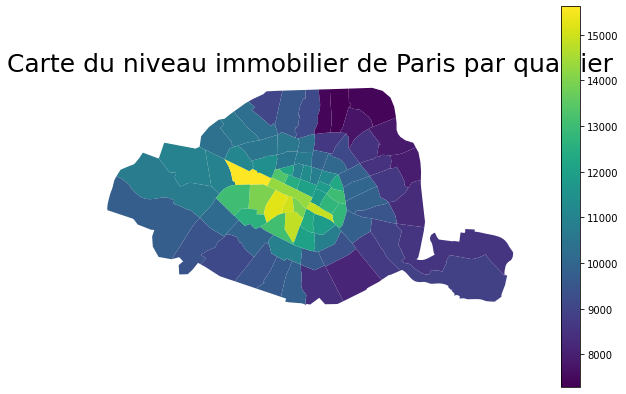

In [223]:
#map du niveau immobilier parisien par quartier
fig, ax = plt.subplots(1, figsize=(10, 7))
map1=gpd.GeoDataFrame(df_quartier)
map1.plot(ax=ax, column='Prix',figsize=(7,7))
ax.axis('off')
ax.set_title("Carte du niveau immobilier de Paris par quartier", fontdict={"fontsize": "25", "fontweight" : "3"})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=map1.Prix.min(), vmax=map1.Prix.max()))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

###1.2 application à chaque bnb : trouver son quartier et y implémenter la valeur immobilière indicative associée à partir de ses coordonnées

In [224]:
air_bnb=Hot.copy()
air_bnb.head()

Price  Bathrooms  ...  Longueur_desc  distance_centre
0   40.0        0.5  ...             33         0.016208
1  140.0        1.0  ...              9         0.018768
2   70.0        1.0  ...            148         0.027639
3  276.0        2.0  ...            170         0.020898
4   85.0        1.0  ...            176         0.023010

[5 rows x 40 columns]

In [225]:
#implémentation de la colonne géométrie
air_bnb["geometry"]=gpd.points_from_xy(air_bnb["Longitude"],air_bnb["Latitude"])

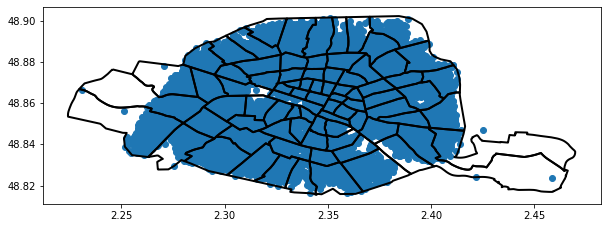

In [226]:
air_bnb_gpd=gpd.GeoDataFrame(air_bnb)
air_bnb_gpd=air_bnb_gpd[(air_bnb_gpd["Latitude"]<49)|(air_bnb_gpd["Latitude"]>48)|(air_bnb_gpd["Longitude"]>2)|(air_bnb_gpd["Longitude"]<2.7)]

# plot the state's boundary with black edge color only and line width of 2
ax = conf_data.geometry.boundary.plot(figsize = (10,15), color = None, edgecolor = 'K', linewidth=2)
# Loop through each event type group 

air_bnb_gpd.plot(ax=ax)

In [227]:
#fonctions utilisées pour attribuer à chaque BnB son quartier selon ses données de géolocalisation. 
def transfuge(x):
  """input: x : (type=coordonnées POINT géopandas)
      (fonction .within)   
      outputs: quartier dans lequel est le point (localisation air bnb)          
"""
  for quartier in df_quartier.index:
    polygone=df_quartier.at[quartier, 'geometry']
    if x.within(polygone):
      return quartier

def pricing (x):
  """ input : x (type=string)
      méthode : asociation clé primaire, clé secondaire
      output : niveau_immobilier du quartier dans lequel est le air_bnb 
  """
  if x in df_quartier.index:
    return (df_quartier.at[x, 'Prix'])


In [228]:
air_bnb_gpd["vrai_quartier"]=air_bnb_gpd["geometry"].apply(transfuge)
air_bnb_gpd["niveau_immobilier"]=air_bnb_gpd["vrai_quartier"].apply(pricing)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


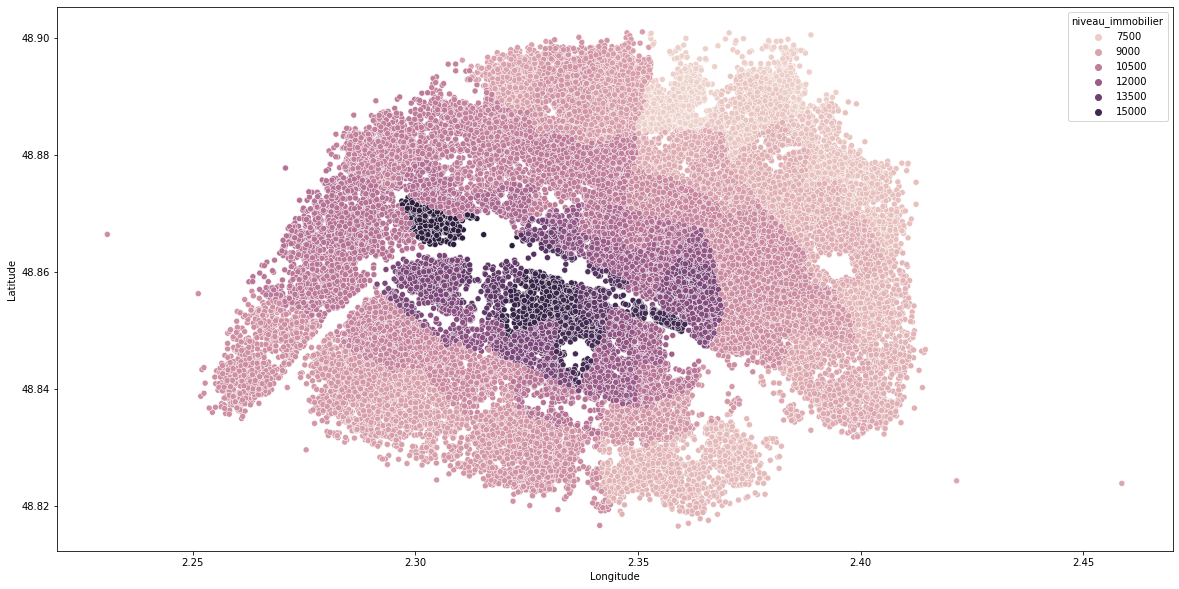

In [229]:
plt.figure(figsize=(20,10))
sns.scatterplot(air_bnb_gpd["Longitude"],air_bnb_gpd["Latitude"],hue=air_bnb_gpd["niveau_immobilier"])
plt.ioff()



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1440x720 with 0 Axes>

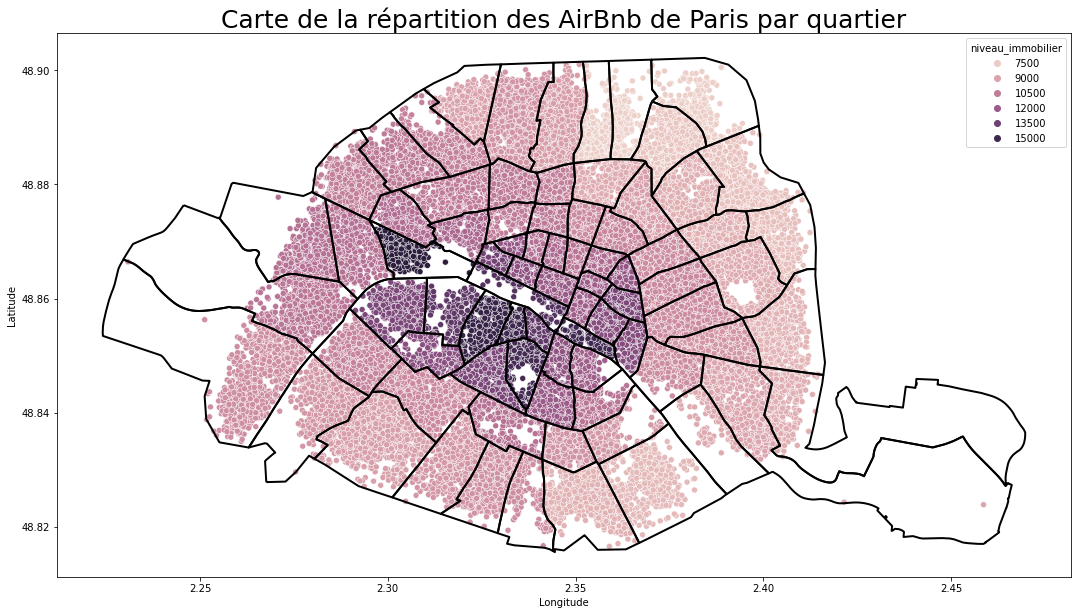

In [230]:
plt.figure(figsize=(20,10))
ax = conf_data.geometry.boundary.plot(figsize = (20,10), color = None, edgecolor = 'K', linewidth=2)

#plt.axis=ax
sns.scatterplot(air_bnb_gpd["Longitude"],air_bnb_gpd["Latitude"],hue=air_bnb_gpd["niveau_immobilier"])
ax.set_title("Carte de la répartition des AirBnb de Paris par quartier", fontdict={"fontsize": "25", "fontweight" : "3"})

plt.ioff()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


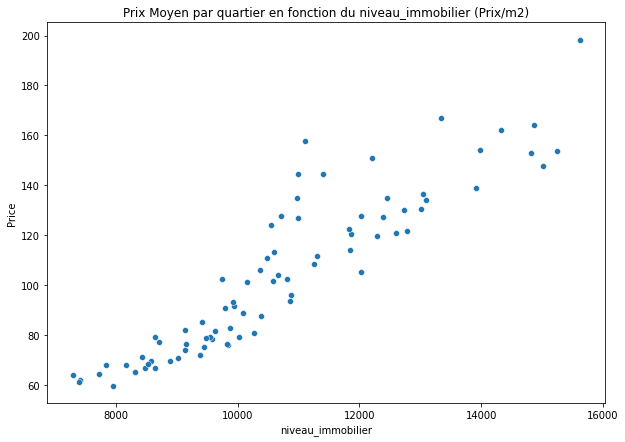

In [231]:
df1=air_bnb_gpd.groupby(["vrai_quartier"]).mean(["Price"])
plt.figure(figsize=(10,7))
plt.title("Prix Moyen par quartier en fonction du niveau_immobilier (Prix/m2)")
sns.scatterplot(df1["niveau_immobilier"],df1.Price)
plt.show()

Ces résultats sont conhérents : le loyer par nuit moyen des air_bnb dépend positivement du niveau immobilier du quartier. 

###1.3 Variables encadrement de Loyer y'a un beug dans cette là faudra que tu le répares hihi

In [ ]:
encad_loy=pd.read_csv("/content/drive/MyDrive/ProjetPython/encadrement_loyers.csv",sep=',')

In [ ]:
df_quartier

n_sq_qu  ...   Prix
Arsenal             750000015  ...  12781
Jardin-des-Plantes  750000018  ...  10858
Porte-Saint-Martin  750000039  ...  10081
Roquette            750000043  ...   9870
Picpus              750000046  ...   8886
...                       ...  ...    ...
Clignancourt        750000070  ...   9148
Goutte-d'Or         750000071  ...   7401
Ecole-Militaire     750000027  ...  12600
Grenelle            750000059  ...  10160
Auteuil             750000061  ...   9747

[80 rows x 9 columns]

In [ ]:
encad_loy=encad_loy[(encad_loy["meuble"]==1)]
encad_loy=encad_loy[(encad_loy["annee"]==2017)]
encad_loy=encad_loy[(encad_loy["ville"]=="PARIS")]

In [ ]:
encad_loy_quartier=encad_loy.groupby(["nom_quartier"]).mean(["ref"])

In [ ]:
l1=encad_loy_quartier.index
L=[]
for s in l1:

  s_no_accents = ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'))
  L.append(s_no_accents)

encad_loy_quartier.index=L

In [ ]:
encad_loy_quartier

id_zone  code_grand_quartier  ...       min       max
Amerique                   13.0            7511975.0  ...  15.44375  26.46875
Archives                    4.0            7510311.0  ...  19.17500  32.85000
Arsenal                     2.0            7510415.0  ...  20.23125  34.66250
Arts-et-Metiers             4.0            7510309.0  ...  19.17500  32.85000
Auteuil                     7.0            7511661.0  ...  18.55000  31.80625
...                         ...                  ...  ...       ...       ...
St-Germain-l'Auxerrois      2.0            7510101.0  ...  20.23125  34.66250
Ternes                      6.0            7511765.0  ...  18.97500  32.52500
Val-de-Grace                4.0            7510519.0  ...  19.17500  32.85000
Villette                   13.0            7511973.0  ...  15.44375  26.46875
Vivienne                    4.0            7510206.0  ...  19.17500  32.85000

[80 rows x 9 columns]

In [ ]:
encad_loy_quartier["index_bis"]=encad_loy_quartier.index

In [ ]:
df_quartier["index_bis"]=df_quartier.index

In [ ]:
df_quartier

n_sq_qu    n_sq_ar  ...   Prix           index_bis
Arsenal             750000015  750000004  ...  12781             Arsenal
Jardin-des-Plantes  750000018  750000005  ...  10858  Jardin-des-Plantes
Porte-Saint-Martin  750000039  750000010  ...  10081  Porte-Saint-Martin
Roquette            750000043  750000011  ...   9870            Roquette
Picpus              750000046  750000012  ...   8886              Picpus
...                       ...        ...  ...    ...                 ...
Clignancourt        750000070  750000018  ...   9148        Clignancourt
Goutte-d'Or         750000071  750000018  ...   7401         Goutte-d'Or
Ecole-Militaire     750000027  750000007  ...  12600     Ecole-Militaire
Grenelle            750000059  750000015  ...  10160            Grenelle
Auteuil             750000061  750000016  ...   9747             Auteuil

[80 rows x 10 columns]

In [ ]:
y=encad_loy_quartier["index_bis"].isin(df_quartier.index_bis)
y.where(y==False).dropna()

Javel 15Art               0.0
La Chapelle               0.0
Plaine de Monceaux        0.0
St-Germain-l'Auxerrois    0.0
Name: index_bis, dtype: float64

In [ ]:
as_list = encad_loy_quartier.index.tolist()
idx = as_list.index('Plaine de Monceaux')
idx2 = as_list.index('La Chapelle')
idx3 = as_list.index('Javel 15Art')
idx4 = as_list.index("St-Germain-l'Auxerrois")
as_list[idx] = 'Plaine-de-Monceaux'
as_list[idx2] = 'La-Chapelle'
as_list[idx3] = 'Javel'
as_list[idx4] = "Saint-Germain-l'Auxerrois"
encad_loy_quartier.index = as_list

In [ ]:
encad_loy_quartier=encad_loy_quartier.drop(["index_bis"],axis=1)
df_quartier=df_quartier.drop(["index_bis"],axis=1)
y.where(y==False).dropna()

Javel 15Art               0.0
La Chapelle               0.0
Plaine de Monceaux        0.0
St-Germain-l'Auxerrois    0.0
Name: index_bis, dtype: float64

In [ ]:
new_df_quartier=df_quartier.join(encad_loy_quartier)
#test=test.sort_index()

In [ ]:
y=encad_loy_quartier["ref"].isin(new_df_quartier["ref"])
#y.where(y==False).dropna()
encad_loy_quartier.sort_index()["ref"].equals(new_df_quartier.sort_index()["ref"])

True

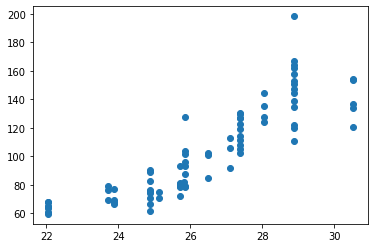

In [ ]:
df1=air_bnb_gpd.groupby(["vrai_quartier"]).mean(["Price"])
plt.scatter(new_df_quartier.sort_index()["ref"],df1.sort_index().Price)
plt.show()

In [ ]:
new_df_quartier["ref"].corr(new_df_quartier["Prix"])

0.857632494348159

Au vu de l'énorme corrélation entre l'encadrement des loyer (=ref) et le niveau immobilier ("Prix") on n'utilisera qu'une seule des 2 variables, nous allons garde le Prix au m2 (=niveau_immobilier dans notre base de air_bnb)

## *2- Variable criminalité*

On ajoute une variable géographique supplémentaire : la criminalité par quatier. Ces données proviennent des services de police et de gendarmeries, il y est décompté le nombre de crime de l'année par département, services de police, et pour paris par arrondissement.

In [232]:
crimi=pd.read_excel("/content/drive/MyDrive/ProjetPython/crimes-et-delits-enregistres-par-les-services-de-gendarmerie-et-de-police-depuis-2012.xlsx",sheet_name='Services PN 2017')

In [233]:
#initialisation de la boucle : calcul du nb de crime moyen par an entre 2012 et 2017 (année de scrap de notre base)
crimi=pd.read_excel("/content/drive/MyDrive/ProjetPython/crimes-et-delits-enregistres-par-les-services-de-gendarmerie-et-de-police-depuis-2012.xlsx",sheet_name='Services PN 2012') 
crimi.index=crimi["Départements"]
crimi.columns=crimi.loc["Libellé index \ CSP",:]
crimi=crimi.drop(["Libellé index \ CSP","Périmètres"],axis=0)
filter_col = [col for col in crimi if col.startswith('DTSP75')]
filter_col = filter_col[:-2]
crimi_paris=crimi[filter_col]
arrondissement = [str(i)+"e arrondissement" for i in range (1,21)]
crimi_paris=crimi_paris.drop(["Infractions au droit de l'urbanisme et de la construction","Fraudes fiscales","Autres délits économiques et financiers"])
Init = crimi_paris.sum(axis=0)

In [234]:
#somme des crimes entre 2012 et 2017
for i in range (3,8):   
    crimi=pd.read_excel("/content/drive/MyDrive/ProjetPython/crimes-et-delits-enregistres-par-les-services-de-gendarmerie-et-de-police-depuis-2012.xlsx",sheet_name='Services PN 201'+str(i)) 
    crimi.index=crimi["Départements"]
    crimi.columns=crimi.loc["Libellé index \ CSP",:]
    crimi=crimi.drop(["Libellé index \ CSP","Périmètres"],axis=0)
    filter_col = [col for col in crimi if col.startswith('DTSP75')]
    filter_col = filter_col[:-1]
    crimi_paris=crimi[filter_col]
    crimi_paris=crimi_paris.drop(["Infractions au droit de l'urbanisme et de la construction","Fraudes fiscales","Autres délits économiques et financiers"])
    Format = crimi_paris.sum(axis=0)
    Init= Init.add(Format,fill_value=0)

In [235]:
#retouches de la base
Init=Init.drop(["DTSP75 STC"])
Init[5]=Init[4]/2+Init[5]
Init[4]=Init[4]/2
for i in range (len(Init)):
  Init[i]=Init[i]/6
arrondissement = [str(i) for i in range (1,21)]
Init.index=arrondissement
Init

1     10130.500000
2      5380.666667
3      5548.000000
4      5481.166667
5      5576.250000
6      8828.916667
7      6588.166667
8     13500.833333
9     11108.000000
10    12706.833333
11    13105.666667
12    10471.166667
13    12672.833333
14    11372.000000
15    14829.333333
16    13115.666667
17    14793.833333
18    19457.666667
19    17725.166667
20    11717.666667
dtype: float64

moyenne des crimes tous confondus entre 2012 et 2017. 

Le premier arrondissement est annormalement haut en moyenne du à une énorme quantité de vols à la tir et autres types de vols : en moyenne représente 50% des crimes commis dans cet arrondissement. Cette valeur permettra de refléter les nuisances sonores et d'activités de l'ultracentre. 

In [236]:
crim_moy=Init.to_frame()
crim_moy.columns=["Crimes Moyens par an"]

Dans la suite on associe la criminalité correspondante à chaque arrondissement

In [237]:
arrondissements=gpd.read_file("/content/drive/MyDrive/ProjetPython/arrondissements.geojson")

In [238]:
#arrond = un catalogue relie nb crime moyen et son arrondissement (avec les coordonnées)
arrond=pd.DataFrame(arrondissements)
arrond.index=arrond["c_ar"]
arrond=arrond.sort_index()
liste_arrondissement = [str(i) for i in range (1,21)]
arrond.index=liste_arrondissement
arrond

n_sq_co  ...                                           geometry
1   750001537  ...  POLYGON ((2.32801 48.86992, 2.32997 48.86851, ...
2   750001537  ...  POLYGON ((2.35152 48.86443, 2.35095 48.86341, ...
3   750001537  ...  POLYGON ((2.36383 48.86750, 2.36389 48.86747, ...
4   750001537  ...  POLYGON ((2.36851 48.85573, 2.36900 48.85374, ...
5   750001537  ...  POLYGON ((2.36443 48.84614, 2.36484 48.84584, ...
6   750001537  ...  POLYGON ((2.34459 48.85405, 2.34428 48.85375, ...
7   750001537  ...  POLYGON ((2.32090 48.86306, 2.32094 48.86305, ...
8   750001537  ...  POLYGON ((2.32584 48.86956, 2.32569 48.86954, ...
9   750001537  ...  POLYGON ((2.33978 48.88203, 2.33982 48.88202, ...
10  750001537  ...  POLYGON ((2.36469 48.88437, 2.36485 48.88436, ...
11  750001537  ...  POLYGON ((2.39624 48.85415, 2.39708 48.85308, ...
12  750001537  ...  POLYGON ((2.41388 48.83357, 2.41401 48.83357, ...
13  750001537  ...  POLYGON ((2.37491 48.83801, 2.37698 48.83610, ...
14  750001537  ...  POLYGON ((2.33381 48.84061, 2.33673 48.83965, ...
15  750001537  ...  POLYGON ((2.29932 48.85217, 2.30088 48.85118, ...
16  750001537  ...  POLYGON ((2.27427 48.87837, 2.27749 48.87796, ...
17  750001537  ...  POLYGON ((2.29517 48.87396, 2.29504 48.87378, ...
18  750001537  ...  POLYGON ((2.36580 48.88554, 2.36469 48.88437, ...
19  750001537  ...  POLYGON ((2.38943 48.90122, 2.39014 48.90108, ...
20  750001537  ...  POLYGON ((2.41277 48.87547, 2.41284 48.87524, ...

[20 rows x 9 columns]

In [239]:
arrondisse=arrond.join(crim_moy)
arrondisse

n_sq_co  ...  Crimes Moyens par an
1   750001537  ...          10130.500000
2   750001537  ...           5380.666667
3   750001537  ...           5548.000000
4   750001537  ...           5481.166667
5   750001537  ...           5576.250000
6   750001537  ...           8828.916667
7   750001537  ...           6588.166667
8   750001537  ...          13500.833333
9   750001537  ...          11108.000000
10  750001537  ...          12706.833333
11  750001537  ...          13105.666667
12  750001537  ...          10471.166667
13  750001537  ...          12672.833333
14  750001537  ...          11372.000000
15  750001537  ...          14829.333333
16  750001537  ...          13115.666667
17  750001537  ...          14793.833333
18  750001537  ...          19457.666667
19  750001537  ...          17725.166667
20  750001537  ...          11717.666667

[20 rows x 10 columns]

In [240]:
def transfuge2(x):
  for a in arrondisse.index:
    polygone=arrondisse.at[a, 'geometry']
    if x.within(polygone):
      return arrondisse.at[a, 'Crimes Moyens par an']

In [241]:
air_bnb_gpd["Criminalité de l'arrondissement"]=air_bnb_gpd["geometry"].apply(transfuge2)
air_bnb_gpd.head()

Price  Bathrooms  ...  niveau_immobilier  Criminalité de l'arrondissement
0   40.0        0.5  ...            12731.0                      5481.166667
1  140.0        1.0  ...            12731.0                      5481.166667
2   70.0        1.0  ...            12781.0                      5481.166667
3  276.0        2.0  ...            12731.0                      5481.166667
4   85.0        1.0  ...            12731.0                      5481.166667

[5 rows x 44 columns]

Bilan on a ajouté le nb de crime moyen de l'arrondissement ou se situe le airbnb

In [242]:
#df1=air_bnb_gpd.copy()
#df1=df1.groupby(["niveau_immobilier"])
#df1=df1[['Price']>150]
#df1=df1[df1["Criminalité de l'arrondissement"]>600]
#df1["Price"]
#plt.scatter(df1["niveau_immobilier"], df1['Price'])
#plt.show()

## *3- Variable concentration de airbnb*

In [243]:
count=air_bnb_gpd.groupby(["vrai_quartier"]).count()
count.head()

Price  ...  Criminalité de l'arrondissement
vrai_quartier           ...                                 
Amerique           733  ...                              734
Archives           533  ...                              533
Arsenal            458  ...                              458
Arts-et-Metiers    603  ...                              603
Auteuil            883  ...                              884

[5 rows x 43 columns]

In [244]:
def concent(c): 
  for quartier in df_quartier.index:
    if c==quartier:
      return count.at[quartier,"Availability 365"]

In [245]:
air_bnb_gpd["concentration"]=air_bnb_gpd["vrai_quartier"].apply(concent)

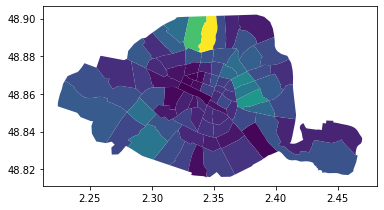

In [246]:
df_quartier["concentration"]=count["Availability 365"]
maps2=gpd.GeoDataFrame(df_quartier)
maps2.plot(column="concentration")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


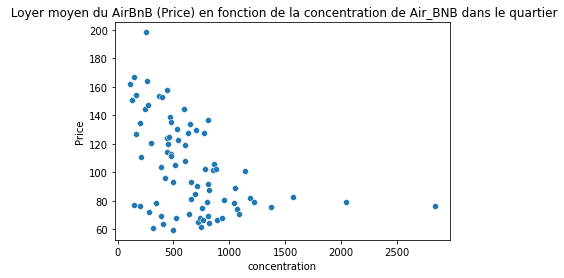

In [248]:
df1=air_bnb_gpd.copy()
df1["nb"]=1
df2=df1.groupby(["concentration"]).mean()
sns.scatterplot(df2.index,df2.Price)
plt.title(""" Loyer moyen du AirBnB (Price) en fonction de la concentration de Air_BNB dans le quartier""")
plt.show()

# **BASE UTILISABLE a mettre à la fin de la partie 3 a la toute fin**

In [249]:
#BASE UTILISABLE AVEC LES SQUARE FEET
base_finale=air_bnb_gpd.drop(["Geolocation","Arrondissement", "Latitude", "Longitude", "geometry", "vrai_quartier"], axis=1)
base_finale

Price  Bathrooms  ...  Criminalité de l'arrondissement  concentration
0       40.0        0.5  ...                      5481.166667          701.0
1      140.0        1.0  ...                      5481.166667          701.0
2       70.0        1.0  ...                      5481.166667          458.0
3      276.0        2.0  ...                      5481.166667          701.0
4       85.0        1.0  ...                      5481.166667          701.0
...      ...        ...  ...                              ...            ...
52083  145.0        1.0  ...                      5481.166667          262.0
52084   65.0        1.0  ...                      5481.166667          453.0
52085  183.0        1.0  ...                      5481.166667          458.0
52086  140.0        1.0  ...                      5481.166667          701.0
52087   59.0        1.0  ...                      5481.166667          701.0

[52088 rows x 39 columns]

In [250]:
base_finale.fillna({'Reviews per Month':0}, inplace=True)

# **IV) Modélisation linéaire sans sélection de features**  

Dans cette partie nous appliquons quatres modèles différents pour inférer le prix du loyer d'une nuit de AirBnB en fonction des différentes variables que nous avons récupérées et mises en forme.

Garder la variable "Square Feet" pose une vrai question structurelle car cela divise par 11 notre base de données. Comme les algorithmes pourront avoir des réponses très différentes selon la taille d'échantillon, conserver une variable qui semble pertinente au prix de diminuer drastiquement la taille de l’échantillon peut s’avérer contre productif.

D’où notre double étude. 

### *1- Avec Square Feet*

In [251]:
base_finale_1=base_finale.dropna()
base_finale_1=base_finale_1.reset_index(drop=True)

In [252]:
base_finale_1

Price  Bathrooms  ...  Criminalité de l'arrondissement  concentration
0      83.0        1.0  ...                      5481.166667          453.0
1     149.0        1.0  ...                      5481.166667          453.0
2      70.0        1.0  ...                      5481.166667          453.0
3      69.0        1.0  ...                      5481.166667          458.0
4     180.0        1.0  ...                      5481.166667          701.0
...     ...        ...  ...                              ...            ...
3198   60.0        1.0  ...                     17725.166667          933.0
3199   85.0        1.0  ...                     12706.833333         1072.0
3200   86.0        1.0  ...                      5481.166667          262.0
3201  150.0        1.0  ...                      5481.166667          701.0
3202  100.0        1.0  ...                      5481.166667          701.0

[3203 rows x 39 columns]

On s'intéresse d'abord à la partie de la modélisation avec une plus petite table d'observations mais prenant en compte la variable Square Feet. Comme on souhaite utiliser des modèles tel qu'une regression linéaire il est important de commencer par régler de potentiels problèmes de multicolinéarité. Pour cela on regarde les valeurs propres de la matrice corr qui correspond à la matrice de corrélation de toutes les features que l'on prend en compte. On réalise qu'on a les quatres dernières valeurs propres qui semblent effectivement très proches de 0 donc il y a bien un problème de multicolinéarité. On cherche alors les variables qui sont fortement corrélées entre elles en choisissant un seuil qui va être ici de 0,7. Ce seuil a été diminué en partant de 1 jusqu'à ce qu'on obtienne des valeurs propres non nuls. On voit finalement qu'il faut supprimer les variables *Bed Type_Real Bed, Beds, Property Type_Loft, Review Scores Value, Room Type_Private room et equipements_rares* pour pallier à ce problème. On garde donc finalement 33 variables pour ces premières modélisations linéaires sans sélection de features.

In [253]:
corr=base_finale_1.corr()
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

array([ 4.69231014e+00,  2.72698972e+00,  2.23670568e+00,  2.10148121e+00,
        1.96732045e+00,  1.82051816e+00,  1.65153327e+00,  1.49954175e+00,
        1.82002183e-01,  2.10098162e-01,  2.55045016e-01,  2.97185997e-01,
        3.22375929e-01,  3.67733483e-01,  3.96431681e-01,  4.54846148e-01,
        6.32873352e-01,  1.21612499e+00,  1.18230358e+00,  6.92870774e-01,
        7.25557054e-01,  7.75668310e-01,  8.10190567e-01,  7.96811609e-01,
        1.11448292e+00,  8.84990487e-01,  9.21929053e-01,  9.46515051e-01,
        9.58773216e-01,  1.05630956e+00,  1.04665979e+00,  1.02865460e+00,
        1.02024497e+00,  1.00943931e+00,  9.97481812e-01, -2.04681759e-14,
        8.07455895e-15,  6.50979210e-15, -5.11807718e-14])

In [254]:
correlated_features = set()
for i in range(len(corr .columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.7:
            colname = corr.columns[i]
            correlated_features.add(colname)

In [255]:
correlated_features

{'Bed Type_Real Bed',
 'Beds',
 'Property Type_Loft',
 'Review Scores Value',
 'Room Type_Private room',
 'equipements_rares'}

In [256]:
var_corr=['Bed Type_Real Bed', 'Beds', 'Property Type_Loft', 'Review Scores Value', 'Room Type_Private room', 'equipements_rares']

In [257]:
base_finale_reg= base_finale_1.drop(columns=var_corr)

In [258]:
corr_reg=base_finale_reg.corr()
multicollinearity, V=np.linalg.eig(corr_reg)
multicollinearity

array([3.82518836, 2.55564584, 1.81162339, 1.73284051, 1.49452005,
       1.41406189, 0.20502628, 0.25425483, 0.27791691, 0.31540033,
       0.37020054, 0.38473597, 0.45304086, 0.51130312, 0.54217473,
       1.18278453, 0.64292697, 1.14265645, 0.73484237, 0.74111015,
       0.75441536, 0.81896236, 1.0965235 , 0.86641245, 0.88708665,
       0.91424813, 0.94865684, 1.05282114, 1.0447726 , 1.02933841,
       1.01414562, 0.98417394, 0.99618889])

Ici on divise notre échantillon d'observations en deux groupes: les données d'apprentissage qui serviront à construire le modèle et les données de test qui permettront de tester les modèles. On a utlisé pour cela la fonction train_test_split qui extrait aléatoirement 70% des observations afin de former le jeu des données d'apprentissage, le reste sera utilisé pour tester les modèles. Il semblait ici peu cohérent de mettre un seuil de test plus petit que 0.3 vu que nous n'avons pas un grand nombre d'observations.

In [259]:
X=base_finale_reg.drop(['Price'],axis=1)
Y=np.log(base_finale_reg['Price'])

scaler=StandardScaler()
X=scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3 )

#### *1.1- Regression linéaire*

On commence par tester le modèle le plus simple pour prédire une variable quantitative: la regression linéaire. On utilise pour cela la class LinearRegression de scikit learn.  

In [260]:
reg = linear_model.LinearRegression()

In [261]:
reg.fit(X_train, y_train)
results=reg.fit(X_test,y_test)
y_pred=reg.predict(X_test)
score=cross_val_score(reg, X, Y, cv=7,scoring='r2')

> Pour avoir un résultat plus cohérent, on utilise la validation croisée basée sur la répétition de l'estimation et de la validation sur des données differentes. Cela permet d'éviter les valeurs aberrantes et d'avoir un algorithme plus robuste. C'est une approche alternative souvent utilisée.

> Nous allons utilisons dans cette partie 4 modèles d'apprentissage supervisé.  L'objectif d'un modèle d'apprentissage supervisé est de prédire une valeur la plus proche possible de la réalité. Notre variable cible ici est une variable quantitative, il existe plusieurs indicateurs de qualité du modèle dans ce cas là. Nous avons choisi ici d'en utiliser 3 différents:
- le R2 qui correspond à la performance du modèle. C'est la proportion de la variance de Price qui est prévisible grâce aux variances de nos features. Plus il est proche de 1 plus le modèle est performant. La validation croisée dont on a parlé plus haut sera effectuée selon ce critère de validation du modèle.
- Le score de chaque modèle qui correspond à la précision du modèle. C'est à dire qu'il compare les valeurs réelles et les valeurs prédites pour les 30% que l'on prédit. Plus il est proche de 1 plus le modèle est précis.
- Le MAE (Mean Absolute Error) qui quantifie les erreurs de prédiction du modèle. Plus il est proche de 0 et plus le modèle est précis.


> On observe que la validation croisée est quand même très utile et permet de ne pas surestimer la qualité de nos modèles. On a ici un R2 de 74,6% sans la validation croisée et de 70,4% avec la validation croisée. La regression linéaire avec nos 33 features dont Square Feet permet donc d'expliquer environ 70% de la variance du prix. On a également un score de précision de 65,9% ce qui est pas mal mais très améliorable.



In [263]:
print('Performance : %f' %reg.score(X_test,y_test)) 
print('Précision : %f' %r2_score(y_pred,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred))
print("R2 de la validation croisée:")
print(np.mean(score))

Performance : 0.705213
Précision : 0.581989
MAE : 0.218671
R2 de la validation croisée:
0.7041637906945662


In [264]:
print(results.coef_)

[ 4.17469627e-02  3.23650624e-03  1.50499678e-01  1.54048573e-01
  3.09474933e-03 -1.07743424e-02 -8.26388784e-03 -1.87945188e-02
  8.44527920e-02  5.58139828e-03  4.01337096e-02 -3.29290691e-02
  2.35734956e-02  4.74984879e-02  2.57077294e-05  4.27296865e-02
 -1.12475400e-02  1.59542723e-02  2.95331023e-02 -3.17601013e-02
  9.30872821e-04  1.02463749e-01 -2.06701629e-02  4.48931920e-03
 -1.18106861e-02 -6.17377544e-03 -3.85613826e-02 -3.19744816e-03
 -2.54633562e-02  1.34656433e-01 -2.93432532e-02 -1.70819523e-02]


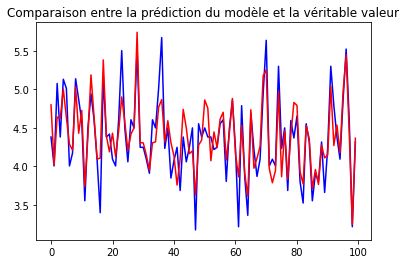

In [265]:
plt.title("Comparaison entre la prédiction du modèle et la véritable valeur")
plt.plot(np.arange(100) , y_test[:100] , color = "blue")
plt.plot(np.arange(100) , y_pred[:100] , color = "red")

Ici on trace les courbes des valeurs réelles et des valeurs prédites pour avoir une meilleure visibilité. On voit que le modèle prédit en moyenne assez bien les données de test mais il y a quand même une bonne marge de progression.

#### *1.2- Regresseur de forêts aléatoires*

On utilise maintenant un deuxième modèle: le Random Forest Regressor. Le principe de la forêt aléatoire s'appuie sur un prélèvement avec remise des éléments de notre base de donnée, et s'entraîne sur chacun des arbres.

In [279]:
random=RandomForestRegressor()
random.fit(X_train, y_train)
results=random.fit(X_test,y_test)
y_pred1=random.predict(X_test)
score1=cross_val_score(random, X, Y, cv=4)
print('Performance : %f' %random.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred1,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred1))
print("R2 de la validation croisée:")
print(np.mean(score1))

Performance : 0.953273
Précision : 0.939480
MAE : 0.085835
R2 de la validation croisée:
0.6887508961784743


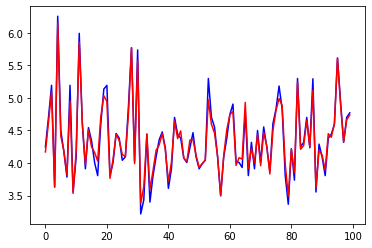

In [ ]:
plt.title("Comparaison entre la prédiction du modèle et la véritable valeur")
plt.plot(np.arange(100) , y_test[:100] , color = "blue")
plt.plot(np.arange(100) , y_pred1[:100] , color = "red")

Il semble à première vue que ce modèle soit extrémement performant, on trouve un score de 95,8% et une précision de 94,8%. Cependant, lorsque l'on réalise la validation croisée, on trouve une précision de 69,3% ce qui semble plus cohérent. La surrestimation de la précision obtenue avec une seule occurence de test peut provenir de valeurs aberrantes dans la base ou d'une autre erreur que nous n'aurions pas détecté auparavant.

#### *1.3 Ridge Regression*

Le troisième modèle que nous allons utilisons est une regression de ridge. Ce modèle minimise la même fonction que la regression linéaire mais en rajoutant un terme de régularisation avec un paramètre alpha positif qui contrôle l'importance de ce terme ajouté. Dans un premier temps, on prendra le alpha par défaut qui vaut 1 mais on cherchera à déterminer le aplha qui optimise notre modèle dans la partie modélisation linéaire avec sélection de features.

In [280]:
ridge=Ridge()
ridge.fit(X_train, y_train)
results=ridge.fit(X_test,y_test)
y_pred2=ridge.predict(X_test)
score2=cross_val_score(ridge, X, Y, cv=7,scoring='r2')
print('Performance : %f' %ridge.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred2,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred2))
print("R2 de la validation croisée:")
print(np.mean(score2))

Performance : 0.705213
Précision : 0.581539
MAE : 0.218660
R2 de la validation croisée:
0.7041678671029812


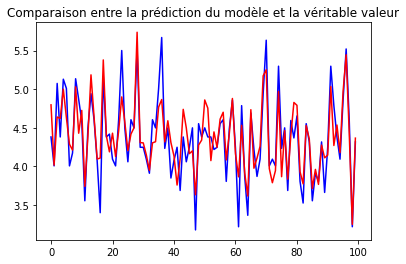

In [270]:
plt.title("Comparaison entre la prédiction du modèle et la véritable valeur")
plt.plot(np.arange(100) , y_test[:100] , color = "blue")
plt.plot(np.arange(100) , y_pred2[:100] , color = "red")

#### *1.4- Lasso Regression*

In [281]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
results=lasso.fit(X_test,y_test)
y_pred3=lasso.predict(X_test)
score3=cross_val_score(lasso, X, Y, cv=7,scoring='r2')
print('Performance : %f' %lasso.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred3,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred3))
print("R2 de la validation croisée:")
print(np.mean(score3))

Performance : 0.705096
Précision : 0.576760
MAE : 0.218559
R2 de la validation croisée:
0.7047247928136127


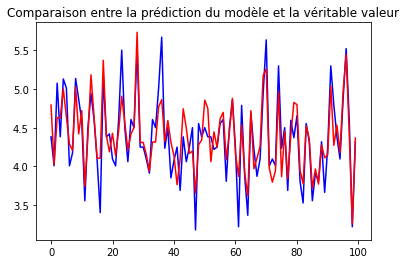

In [273]:
plt.title("Comparaison entre la prédiction du modèle et la véritable valeur")
plt.plot(np.arange(100) , y_test[:100] , color = "blue")
plt.plot(np.arange(100) , y_pred3[:100] , color = "red")

#### *1.5- Comparaison des modèles*

In [274]:
print('-------------Linear Regression-----------')
print('Performance : %f' %reg.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred))

print('---------------Random Forest-------------------')
print('Performance : %f' %random.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred1,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred1))


print('---------------Ridge ---------------------')
print('Performance : %f' %ridge.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred2,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred2))

print('---------------Lasso-----------------------')
print('Performance : %f' %lasso.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred3,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred3))

-------------Linear Regression-----------
Performance : 0.705213
Précision : 0.581989
MAE : 0.218671
---------------Random Forest-------------------
Performance : 0.954387
Précision : 0.941038
MAE : 0.085790
---------------Ridge ---------------------
Performance : 0.705213
Précision : 0.581539
MAE : 0.218660
---------------Lasso-----------------------
Performance : 0.705096
Précision : 0.576760
MAE : 0.218559


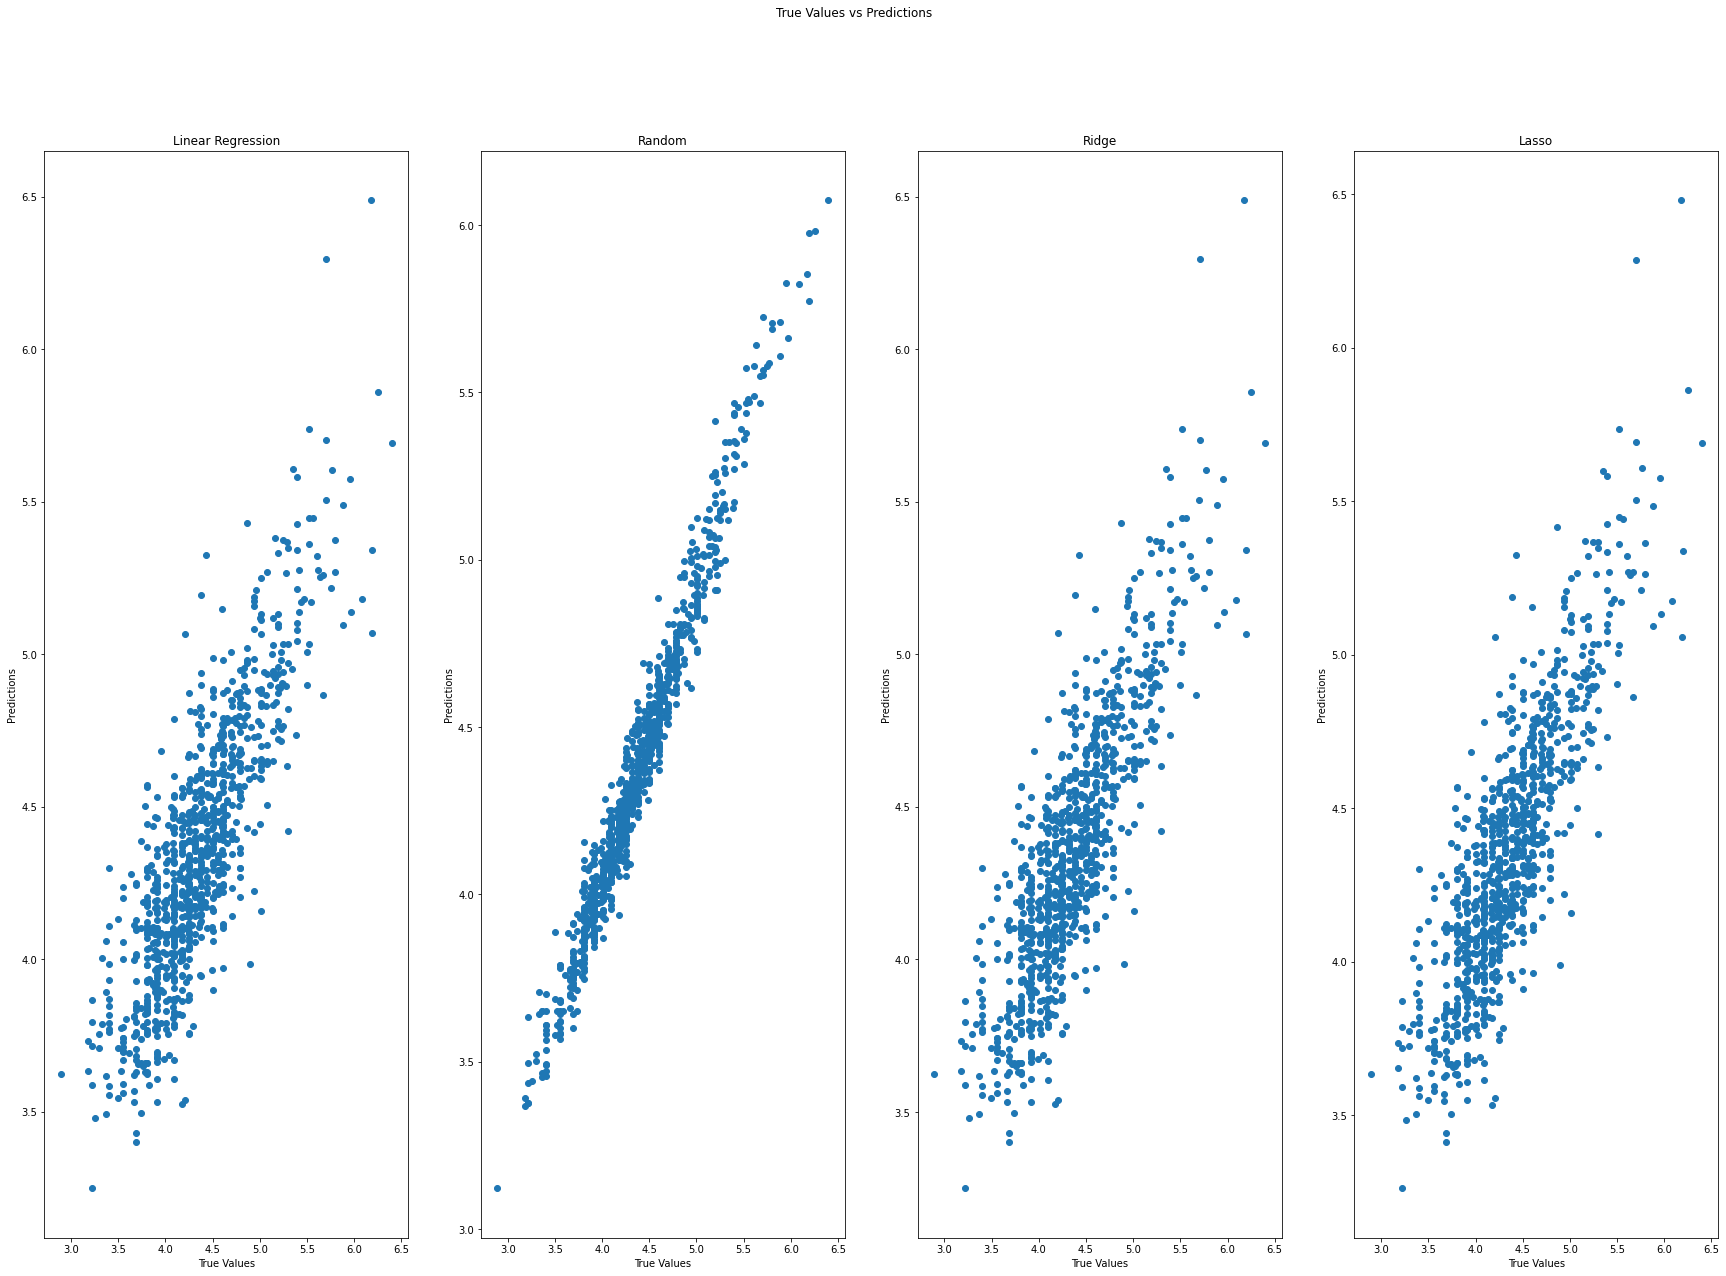

In [275]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(30, 20))
fig.suptitle('True Values vs Predictions')

ax1.scatter(y_test, y_pred)
ax1.set_title('Linear Regression')

ax2.scatter(y_test, y_pred1)
ax2.set_title('Random')

ax3.scatter(y_test, y_pred2)
ax3.set_title('Ridge')

ax4.scatter(y_test, y_pred3)
ax4.set_title('Lasso')

for ax in fig.get_axes():
    ax.set(xlabel='True Values', ylabel='Predictions')

In [277]:
print("Moyenne des R^2 sur 7 tests différents:")
print("Linear Regression:")
print(np.mean(cross_val_score(reg, X, Y, cv=7,scoring='r2')))
print("Random Forest Regression:")
print(np.mean(cross_val_score(random, X, Y, cv=4,scoring='r2')))
print("Ridge Regression:")
print(np.mean(cross_val_score(ridge, X, Y, cv=7,scoring='r2')))
print("Lasso Regression:")
print(np.mean(cross_val_score(lasso, X, Y, cv=7,scoring='r2')))

Moyenne des R^2 sur 7 tests différents:
Linear Regression:
0.7041637906945662
Random Forest Regression:
0.6860634055727097
Ridge Regression:
0.7041678671029812
Lasso Regression:
0.7047247928136127


Text(0, 0.5, 'MCE')

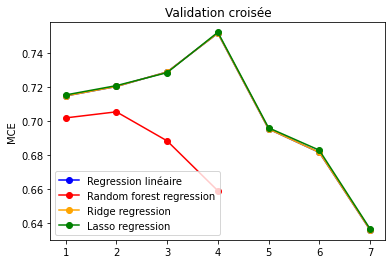

In [286]:
plt.plot([1,2,3,4,5,6,7],score , marker = 'o', color = "blue" , label = "Regression linéaire")
plt.plot([1,2,3,4],score1 , marker = 'o', color = "red" , label = "Random forest regression")
plt.plot([1,2,3,4,5,6,7],score2 , marker = 'o' , color ="orange" , label = "Ridge regression")
plt.plot([1,2,3,4,5,6,7],score3 , marker = 'o' , color ="green" , label = "Lasso regression")
plt.legend()
plt.title("Validation croisée")
plt.ylabel("R2")

### *2- Sans Square Feet*

In [289]:
data_sanssq=base_finale.drop(['Square Feet'],axis=1)
data_sanssq=data_sanssq.dropna()
data_sanssq=data_sanssq.reset_index(drop=True)
data_sanssq_reg=data_sanssq.drop(var_corr,axis=1)

In [290]:
X_bis=data_sanssq_reg.drop(['Price'],axis=1)
Y_bis=np.log(data_sanssq_reg['Price'])

scaler=StandardScaler()
X_bis=scaler.fit_transform(X_bis)

X_train_bis, X_test_bis, y_train_bis, y_test_bis = train_test_split(X_bis, Y_bis, test_size=0.1)

#### *2.1- Regression linéaire*

In [291]:
reg.fit(X_train_bis, y_train_bis)
results=reg.fit(X_test_bis,y_test_bis)
y_pred_bis=reg.predict(X_test_bis)
score=cross_val_score(reg, X_bis, Y_bis, cv=7,scoring='r2')
print('Performance : %f' %reg.score(X_test_bis,y_test_bis))
print('Précision : %f' %r2_score(y_pred_bis,y_test_bis))
print('MAE : %f' %mean_absolute_error(y_test_bis, y_pred_bis))
print("R2 de la validation croisée:")
print(np.mean(score))

Performance : 0.693742
Précision : 0.558543
MAE : 0.234792
R2 de la validation croisée:
0.7007694822231284


In [292]:
print(results.coef_)

[ 4.69011886e-02  1.34695845e-01  1.54577003e-01  4.76386118e-03
 -1.19374402e-02  2.61463690e-03 -3.23798843e+02  8.93455612e-02
  1.50468523e-02  4.79593165e-02 -3.46951246e-02  2.95629823e-02
  3.64139441e-02  7.36308403e-03  4.04369525e-02  2.13795728e-03
 -1.69669705e-03  3.04685005e-02 -1.78298982e-02 -1.39013068e-02
  1.23388588e-01 -2.19398303e-02 -7.50077461e-03 -9.47562930e-03
 -5.10300193e-03 -2.28776410e-02  5.81438508e-03 -2.89155680e-02
  1.65504741e-01  3.09849275e-03 -9.55628867e-03]


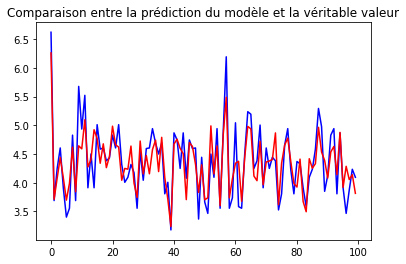

In [293]:
plt.title("Comparaison entre la prédiction du modèle et la véritable valeur")
plt.plot(np.arange(100) , y_test_bis[:100] , color = "blue")
plt.plot(np.arange(100) , y_pred_bis[:100] , color = "red")

#### *2.2- Random Forest Regressor*

In [294]:
random.fit(X_train_bis, y_train_bis)
results=random.fit(X_test_bis,y_test_bis)
y_pred_bis1=random.predict(X_test_bis)
score1=cross_val_score(random, X_bis, Y_bis, cv=4,scoring='r2')
print('Performance : %f' %random.score(X_test_bis,y_test_bis))
print('Précision : %f' %r2_score(y_pred_bis1,y_test_bis))
print('MAE : %f' %mean_absolute_error(y_test_bis, y_pred_bis1))
print("R2 de la validation croisée:")
print(np.mean(score1))

Performance : 0.956452
Précision : 0.945822
MAE : 0.087133
R2 de la validation croisée:
0.731634662395303


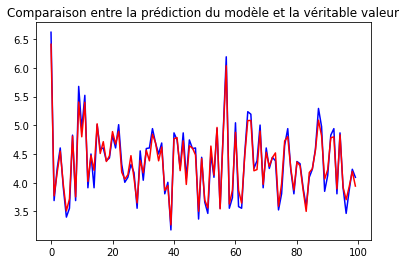

In [295]:
plt.title("Comparaison entre la prédiction du modèle et la véritable valeur")
plt.plot(np.arange(100) , y_test_bis[:100] , color = "blue")
plt.plot(np.arange(100) , y_pred_bis1[:100] , color = "red")

#### 2.3- Ridge Regression

In [296]:
ridge.fit(X_train_bis, y_train_bis)
results=ridge.fit(X_test_bis,y_test_bis)
y_pred_bis2=ridge.predict(X_test_bis)
score2=cross_val_score(ridge, X_bis, Y_bis, cv=7,scoring='r2')
print('Performance : %f' %ridge.score(X_test_bis,y_test_bis))
print('Précision : %f' %r2_score(y_pred_bis2,y_test_bis))
print('MAE : %f' %mean_absolute_error(y_test_bis, y_pred_bis2))
print("R2 de la validation croisée:")
print(np.mean(score2))

Performance : 0.693279
Précision : 0.557466
MAE : 0.235020
R2 de la validation croisée:
0.7007695233579562


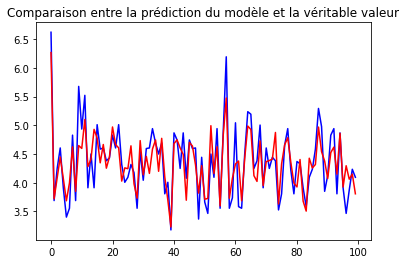

In [297]:
plt.title("Comparaison entre la prédiction du modèle et la véritable valeur")
plt.plot(np.arange(100) , y_test_bis[:100] , color = "blue")
plt.plot(np.arange(100) , y_pred_bis2[:100] , color = "red")

#### *2.4- Lasso Regression*

In [303]:
lasso.fit(X_train_bis, y_train_bis)
results=lasso.fit(X_test_bis,y_test_bis)
y_pred_bis3=lasso.predict(X_test_bis)
score3=cross_val_score(lasso, X_bis, Y_bis, cv=7,scoring='r2')
print('Performance : %f' %lasso.score(X_test_bis,y_test_bis))
print('Précision : %f' %r2_score(y_pred_bis3,y_test_bis))
print('MAE : %f' %mean_absolute_error(y_test_bis, y_pred_bis3))
print("R2 de la validation croisée:")
print(np.mean(score3))

Performance : 0.693180
Précision : 0.552805
MAE : 0.235026
R2 de la validation croisée:
0.7007757066403376


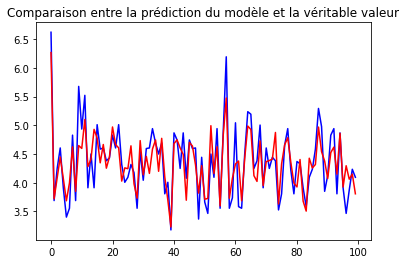

In [304]:
plt.title("Comparaison entre la prédiction du modèle et la véritable valeur")
plt.plot(np.arange(100) , y_test_bis[:100] , color = "blue")
plt.plot(np.arange(100) , y_pred_bis2[:100] , color = "red")

#### *2.5- Comparaison des modèles*

In [305]:
print('-------------Linear Regression-----------')
print('Performance : %f' %reg.score(X_test_bis,y_test_bis))
print('Précision : %f' %r2_score(y_pred_bis,y_test_bis))
print('MAE : %f' %mean_absolute_error(y_test_bis, y_pred_bis))

print('---------------Random Forest-------------------')
print('Performance : %f' %random.score(X_test_bis,y_test_bis))
print('Précision : %f' %r2_score(y_pred_bis1,y_test_bis))
print('MAE : %f' %mean_absolute_error(y_test_bis, y_pred_bis1))


print('---------------Ridge ---------------------')
print('Performance : %f' %ridge.score(X_test_bis,y_test_bis))
print('Précision : %f' %r2_score(y_pred_bis2,y_test_bis))
print('MAE : %f' %mean_absolute_error(y_test_bis, y_pred_bis2))

print('---------------Lasso-----------------------')
print('Performance : %f' %lasso.score(X_test_bis,y_test_bis))
print('Précision : %f' %r2_score(y_pred_bis3,y_test_bis))
print('MAE : %f' %mean_absolute_error(y_test_bis, y_pred_bis3))

-------------Linear Regression-----------
Performance : 0.693742
Précision : 0.558543
MAE : 0.234792
---------------Random Forest-------------------
Performance : 0.956452
Précision : 0.945822
MAE : 0.087133
---------------Ridge ---------------------
Performance : 0.693279
Précision : 0.557466
MAE : 0.235020
---------------Lasso-----------------------
Performance : 0.693180
Précision : 0.552805
MAE : 0.235026


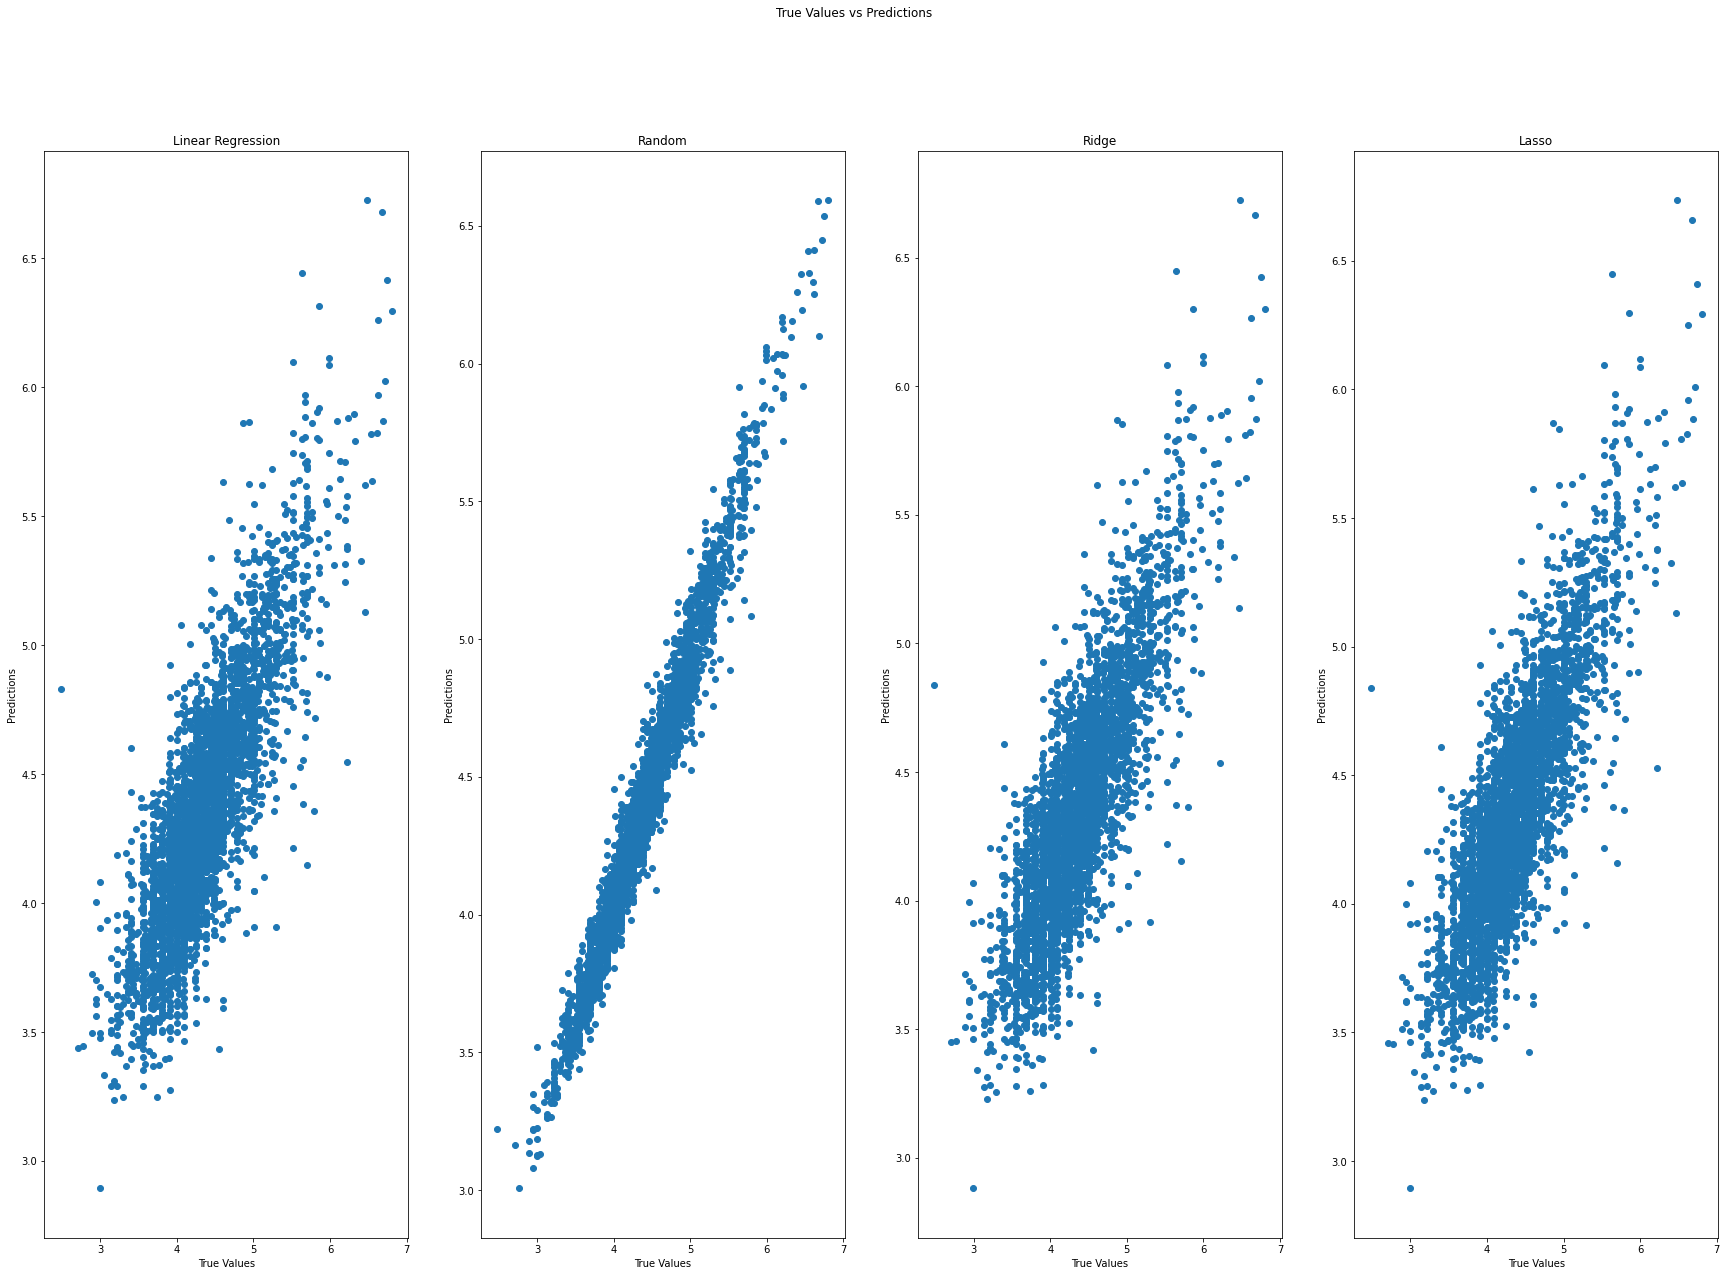

In [306]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(30, 20))
fig.suptitle('True Values vs Predictions') 

ax1.scatter(y_test_bis, y_pred_bis)
ax1.set_title('Linear Regression') 

ax2.scatter(y_test_bis, y_pred_bis1)
ax2.set_title('Random') 

ax3.scatter(y_test_bis, y_pred_bis2)
ax3.set_title('Ridge') 

ax4.scatter(y_test_bis, y_pred_bis3)
ax4.set_title('Lasso')

for ax in fig.get_axes():    
  ax.set(xlabel='True Values', ylabel='Predictions')

Text(0, 0.5, 'R2')

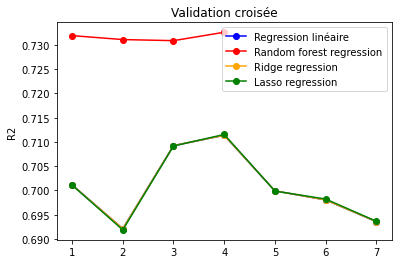

In [307]:
plt.plot([1,2,3,4,5,6,7],score , marker = 'o', color = "blue" , label = "Regression linéaire")
plt.plot([1,2,3,4],score1 , marker = 'o', color = "red" , label = "Random forest regression")
plt.plot([1,2,3,4,5,6,7],score2 , marker = 'o' , color ="orange" , label = "Ridge regression")
plt.plot([1,2,3,4,5,6,7],score3 , marker = 'o' , color ="green" , label = "Lasso regression")
plt.legend()
plt.title("Validation croisée")
plt.ylabel("R2")

# **IV) Sélection de Feature**

### *1- A la main (matrice de corrélation, taille du sample...)*

In [ ]:
#fonction de corrélation 
def correlation(df):
  corrélation=df.corr()
  sns.heatmap(corrélation, square = True)

In [ ]:
correlation(base_finale_1)

In [ ]:
X=base_finale_1.drop(['Price'],axis=1)
Y=np.log(base_finale_1['Price'])
lab_enc = preprocessing.LabelEncoder()
selection = ExtraTreesClassifier(n_estimators=50)
selection.fit(X,lab_enc.fit_transform(Y))

plt.figure(figsize=(10,10))
feat_importances = pd.Series(selection.feature_importances_, index=base_finale_1.iloc[:,:-1].columns)
feat_importances.nlargest(38).plot(kind='barh')

In [ ]:
#pour les modèles linéaires
X=base_finale_reg.drop(['Price'],axis=1)
Y=np.log(base_finale_reg['Price'])
lab_enc = preprocessing.LabelEncoder()
selection = ExtraTreesClassifier(n_estimators=50)
selection.fit(X,lab_enc.fit_transform(Y))

plt.figure(figsize=(10,10))
feat_importances = pd.Series(selection.feature_importances_, index=base_finale_reg.iloc[:,:-1].columns)
feat_importances.nlargest(38).plot(kind='barh')

### *2- Méthode lasso*

In [ ]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [ ]:
Y=base_finale_1["Price"]
X=base_finale_1.drop(["Price"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
X_train.shape, X_test.shape

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

sel_.get_support()

In [ ]:
select_lasso=pd.Series(sel_.get_support(),index=list(base_finale_1.drop(["Price"],axis=1)))
select_lasso["Price"]=True
print(select_lasso)

In [ ]:
base_finale_partie_5=base_finale_1[select_lasso.index[select_lasso]]
base_finale_partie_5.head()

Cette feature selection élimine donc 

# **V) Modélisation linéaire avec sélection de features**

refaire partie 3 mais avec uniquement les features sélectionnés et essayer d'améliorer les paramètres de chaque modèle avec gridsearch

### *1- Avec Square Feet*

In [ ]:
base_finale_1=base_finale_partie_5.dropna()
base_finale_1
base_finale_1=base_finale_1.reset_index(drop=True)

In [ ]:
corr=base_finale_1.corr()
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

In [ ]:
correlated_features = set()
for i in range(len(corr .columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.7:
            colname = corr.columns[i]
            correlated_features.add(colname)

In [ ]:
correlated_features

In [ ]:
var_corr=['Beds', 'Review Scores Value']

In [ ]:
base_finale_reg= base_finale_1.drop(columns=var_corr)

In [ ]:
corr_reg=base_finale_reg.corr()
multicollinearity, V=np.linalg.eig(corr_reg)
multicollinearity

In [ ]:
X=base_finale_reg.drop(['Price'],axis=1)
Y=np.log(base_finale_reg['Price'])

scaler=StandardScaler()
X=scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3 )

#### *1.1- Regression linéaire*

In [ ]:
#Mean Absolute Error (MAE) shows the difference between predictions and actual values.

#Root Mean Square Error (RMSE) shows how accurately the model predicts the response.

#R^2 will be calculated to find the goodness of fit measure.

Réflexion sur les hyper paramètres de la régression linéaire à l'aide du package GridSearch

In [ ]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
# Building Grid Search algorithm with cross-validation and Mean Squared Error score.
#paramètres par défaut: normalize=False, fit_intercept=True, copy_X=True
grid_search_LR = GridSearchCV(estimator=reg,  param_grid=parameters, scoring='neg_mean_absolute_error')
#finding best paramètres
grid_search_LR.fit(X_train, y_train)
best_parameters_LR = grid_search_LR.best_params_  
print(best_parameters_LR)
print(grid_search_LR.best_score_)

# regarde ce kaggle si besoin https://www.kaggle.com/duygut/airbnb-nyc-price-prediction

In [ ]:
reg = linear_model.LinearRegression(best_parameters_LR)

In [ ]:
reg.fit(X_train, y_train)
results=reg.fit(X_test,y_test)
y_pred=reg.predict(X_test)
print('Performance : %f' %reg.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred))

In [ ]:
print(results.coef_)

#### *1.2- Random Forest Regression*

Réflexions sur les hyper paramètres avec le Grid Search. Dans les faits inutilisable pour Random Forest car l'algorithme tourne en énormément de temps. (6 sec par fit, pour 11 880 en tout soit environ 20h). 

In [ ]:
# parameters = {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# # Building Grid Search algorithm with cross-validation and Mean Squared Error score.
# #paramètres par défaut: normalize=False, fit_intercept=True, copy_X=True
# grid_search = GridSearchCV(estimator = random, param_grid = parameters, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# random=RandomForestRegressor()
# #finding best paramètres
# grid_search.fit(X_train, y_train)
# best_parameters = grid_search.best_params_  
# print(best_parameters)
# print(grid_search.best_score_)


In [ ]:
random=RandomForestRegressor()
random.fit(X_train, y_train)
results=random.fit(X_test,y_test)
y_pred1=random.predict(X_test)
print('Performance : %f' %random.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred1,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred1))

#### *1.3 Ridge Regression*

In [ ]:
ridge=Ridge()
ridge.fit(X_train, y_train)
results=ridge.fit(X_test,y_test)
y_pred2=ridge.predict(X_test)
print('Performance : %f' %ridge.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred2,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred2))

#### *1.4- Lasso Regression*

In [ ]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
results=lasso.fit(X_test,y_test)
y_pred3=lasso.predict(X_test)
print('Performance : %f' %lasso.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred3,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred3))

#### *1.5- Comparaison des modèles*

In [ ]:
print('-------------Linear Regression-----------')
print('Performance : %f' %reg.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred))

print('---------------Random Forest-------------------')
print('Performance : %f' %random.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred1,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred1))


print('---------------Ridge ---------------------')
print('Performance : %f' %ridge.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred2,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred2))

print('---------------Lasso-----------------------')
print('Performance : %f' %lasso.score(X_test,y_test))
print('Précision : %f' %r2_score(y_pred3,y_test))
print('MAE : %f' %mean_absolute_error(y_test, y_pred3))

In [ ]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(30, 20))
fig.suptitle('True Values vs Predictions')

ax1.scatter(y_test, y_pred)
ax1.set_title('Linear Regression')

ax2.scatter(y_test, y_pred1)
ax2.set_title('Random')

ax3.scatter(y_test, y_pred2)
ax3.set_title('Ridge')

ax4.scatter(y_test, y_pred3)
ax4.set_title('Lasso')

for ax in fig.get_axes():
    ax.set(xlabel='True Values', ylabel='Predictions')

# **VI) Partie ouverture: modèle XGBoost et tensor flow**

### *1- Modèle XGBoost*

#### *1.1- Avec Square Feet*

In [ ]:
X2=base_finale_1.drop(['Price'],axis=1)
Y2=np.log(base_finale_1['Price'])

In [ ]:
scaler=StandardScaler()
X2=scaler.fit_transform(X2)
X2

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,Y2, test_size=0.3, random_state=42)

In [ ]:
modelxgb=XGBRegressor()

In [ ]:
modelxgb.fit(X_train2,y_train2)

In [ ]:
modelxgb.score(X_test2, y_test2) 

In [ ]:
y_pred = modelxgb.predict(X_test2)
r2_score(y_pred, y_test2)

In [ ]:
print('MAE: %f'% mean_absolute_error(y_pred, y_test2))
print('MSE: %f'% mean_squared_error(y_pred, y_test2))

#### *1.2- Sans Square Feet*

In [ ]:
X2_bis=data_sanssq.drop(['Price'],axis=1)
Y2_bis=np.log(data_sanssq['Price'])

scaler=StandardScaler()
X2_bis=scaler.fit_transform(X2_bis)

X_train2_bis, X_test2_bis, y_train2_bis, y_test2_bis = train_test_split(X2_bis,Y2_bis, test_size=0.3, random_state=42)

modelxgb=XGBRegressor()

modelxgb.fit(X_train2_bis,y_train2_bis)
y_pred = modelxgb.predict(X_test2_bis)

modelxgb.score(X_test2_bis, y_test2_bis) 

In [ ]:
print('r2_score: %f'% r2_score(y_pred, y_test2_bis))
print('MAE: %f'% mean_absolute_error(y_pred, y_test2_bis))
print('MSE: %f'% mean_squared_error(y_pred, y_test2_bis))

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
 
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 
X_train, X_test, y_train, y_test = train_test_split(dff_2, Y3, test_size=0.33, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [ ]:
# make a regression prediction with an RFE pipeline
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# define dataset
# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# fit the model on all available data
pipeline.fit(dff_2, Y3)
# make a prediction for one example
yhat = pipeline.predict(X_test3)
print('Predicted: %.3f' % (yhat))

### *2- Modèle TensorFlow (Deep Learning)*

In [ ]:
from sklearn.preprocessing import MinMaxScaler


In [ ]:
X=base_finale_1.drop(['Price'],axis=1)
Y=base_finale_1['Price']
scaler = StandardScaler()

X= scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense #Dense Fully Connected Layer Type
from tensorflow.keras.optimizers import SGD #Stochastic Gradient Descent Optimizer
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.losses import MSE

def baseline_model():
  # create model
	model = Sequential()
	model.add(Dense(13, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
	model.add(Dense(6, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=20, verbose=0)
kfold = KFold(n_splits=5)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:

losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
predictions = model.predict(X_test)
print(mean_absolute_error(y_test,predictions))
print(np.sqrt(mean_squared_error(y_test,predictions)))


In [ ]:
import tensorflow as tf

total_error = tf.reduce_sum(tf.square(tf.subtract(y_test, tf.reduce_mean(y_test))))
unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_test,predictions)))
R_squared = tf.subtract(1, tf.divide(unexplained_error, total_error))
print(R_squared)

In [ ]:
# custom R2-score metrics for keras backend
from tensorflow.keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
(y_test,predictions.tolist())

# **Conclusion:**

- comparaison des modèles
- ouverture: beaucoup de features, peut être on pourrait faire une meilleure selection, var description, on utilise pas les photos donc la beauté de l'appart, on aurait pu faire avec des classifier et des classes de prix la on prédit dans R donc dur